### Import libraries and utilities

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from scipy.stats import pearsonr, spearmanr
from math import log
import itertools
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.weightstats import CompareMeans
sns.set_theme(style="whitegrid")

In [29]:
# all exploratory numeric features
num_feature = ['danceability', 'energy', 'loudness',
               'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']

# for discretizing data
eras = [1980, 1990, 2000, 2010, 2015, 2018]
eras_name = ["<1980", "1980s", "1990s", "2000s", "2010-2014", "2015-2017", "2018-now"]
popularity = [0, 5e8]

# for converting some categorical variables
key_dict = {
    "0": "C",
    "1": "C♯",
    "2": "D",
    "3": "D♯",
    "4": "E",
    "5": "F",
    "6": "F♯",
    "7": "G",
    "8": "G♯",
    "9": "A",
    "10": "A♯",
    "11": "B"
}
mode = ["minor", "major"]



# group of functions used for converting data into human readable form
def convert_key(col):
    return col.apply(lambda x: key_dict[str(x)])


def convert_mode(col):
    return col.apply(lambda x: mode[x])


def convert_time_sig(col):
    return col.apply(lambda x: "{}/4".format(x))


def convert_duration(col):
    return col.apply(lambda x: sum(mul * int(x) for mul, x in zip([60, 1], x.split(":"))))


def convert_explicit(x):
    if x == 0:
        return 'No'
    elif x == 1:
        return 'Yes'


def convert_data(df):
    copy = df.copy()
    copy['key'] = convert_key(copy['key'])
    copy['mode'] = convert_mode(copy['mode'])
    copy['time_signature'] = convert_time_sig(copy['time_signature'])
    copy['duration'] = convert_duration(copy['duration'])
    copy["sp_release_date"] = pd.to_datetime(
        copy['sp_release_date'], format='%Y-%m-%d')
    copy["explicit"] = copy["explicit"].apply(convert_explicit)
    return copy


def filter_p_value(x, threshold=0.05):
    if x < threshold:
        return 0
    else:
        return 1


def get_corr_matrix(df, feature, p=False):
    """
    Get pearson and spearman correlation between each exploratory numeric variables and each response variable (Spotify and Youtube playcounts)
    Input:
        df: DataFrame
            the dataframe containing the information of the songs
        feature: list 
            list of numeric features
        p: bool
            whether to return the p value matrix 
    Output: DataFrame
    """

    # correlation value
    pearson_view = {}
    pearson_playcount = {}
    spearman_view = {}
    spearman_playcount = {}
    # p values of those corr value
    pp_view = {}
    pp_playcount = {}
    sp_view = {}
    sp_playcount = {}

    # compute corrs and p values
    for col in feature:
        pearson_playcount[col], pp_playcount[col] = pearsonr(
            df['playcount'], df[col])
        pearson_view[col], pp_view[col] = pearsonr(df['view'], df[col])
        spearman_view[col], sp_view[col] = spearmanr(df['view'], df[col])
        spearman_playcount[col], sp_playcount[col] = spearmanr(
            df['playcount'], df[col])

    # build the matrix with columns = numeric features, rows = types of correlation
    corr = pd.DataFrame(columns=feature)
    corr = corr.append(pearson_playcount, ignore_index=True)
    corr = corr.append(pearson_view, ignore_index=True)
    corr = corr.append(spearman_playcount, ignore_index=True)
    corr = corr.append(spearman_view, ignore_index=True)
    corr['type'] = ['pearson_playcount', 'pearson_view',
                    'spearman_playcount', 'spearman_view']
    corr = corr.set_index("type")

    if p:
        # build the corresponding p value matrix as well
        p_value = pd.DataFrame(columns=feature)
        p_value = p_value.append(pp_playcount, ignore_index=True)
        p_value = p_value.append(pp_view, ignore_index=True)
        p_value = p_value.append(sp_playcount, ignore_index=True)
        p_value = p_value.append(sp_view, ignore_index=True)
        return corr, pd.DataFrame(p_value).applymap(filter_p_value)

    return corr


def findsubsets(S, m):
    return set(itertools.combinations(S, m))


class ConfusionMatrix():
    """
    Custom confusion matrix class for computing genre cooccurence
    """
    def __init__(self, list):
        """ 
        Initialize with the list of genres. This will be used as the row and column names of the matrix 
        """
        self.ele = list
        self.size = len(list)
        self.matrix = np.zeros((len(list), len(list)))

    def increment(self, pair):
        first_ele, second_ele = pair
        first_i = self.ele.index(first_ele)
        second_i = self.ele.index(second_ele)
        self.matrix[first_i, second_i] += 1
        self.matrix[second_i, first_i] += 1

    def update_diag(self, ele, value):
        i = self.ele.index(ele)
        self.matrix[i, i] = value
    def normalize(self):
        """
        Divide each value in the matrix (except the values on the diagonal) by the its expected value
        """
        total = np.diag(self.matrix).sum()
        for i in range(self.size):
            for j in range(i):
                self.matrix[i, j] /= self.matrix[i, i] * \
                    self.matrix[j, j] / total
                self.matrix[j, i] = self.matrix[i, j]

    def reset_diag(self):
        """
        Set the values on the diagonal to zero
        """
        for i in range(self.size):
            self.matrix[i, i] = 0


def gini(df, col):
    """
    Compute gini index on a column of a dataframe
    """
    counts = df[col].value_counts()
    prob = counts / counts.sum()
    return 1 - (prob ** 2).sum()


def entropy(df, col):
    """
    Compute entropy on a column of a dataframe
    """
    counts = df[col].value_counts()
    prob = counts / counts.sum()
    return 0 - (prob * prob.apply(log)).sum()


def plot_popularity_by_year(data, **kwargs):
    """
    Plot the mean number of playcounts in each year
    """
    # find the mean in each year
    df_year = data.copy()
    df_year['year'] = df['sp_release_date'].dt.year
    popularity_by_year = df_year.groupby("year")[["playcount", "view"]].mean()

    # years with no song will have mean view and playcount of 0; also convert everything to float since map_dataframe wants that for some reason
    popularity_by_year.rename(
        columns={'playcount': 'Spotify', 'view': 'Youtube'}, inplace=True)
    popularity_by_year.index = popularity_by_year.index.astype('float64')
    all_year = set(popularity_by_year.index)
    earliest = min(all_year)
    latest = max(all_year)
    for year in range(int(earliest)+1, int(latest)):
        year = float(year)
        if year not in all_year:
            popularity_by_year = popularity_by_year.append(pd.DataFrame(
                [[0, 0]], columns=popularity_by_year.columns, index=[year]))
    
    sns.lineplot(data=popularity_by_year)


def plot_popularity_by_eras(data, ax=None, mode='mean', **kwargs):
    """
    Plot the mean number of playcounts in each year
    """
    df_year = data.copy()
    df_year['year'] = df['sp_release_date'].dt.year
    if mode == 'mean':
        eras_avg = discretize(data=df_year, col='year', value_range=eras, inf='both').groupby(
        'year')[['playcount', 'view']].mean()
    elif mode == 'median':
        eras_avg = discretize(data=df_year, col='year', value_range=eras, inf='both').groupby(
        'year')[['playcount', 'view']].median()
    eras_avg.rename(columns={'playcount': 'Spotify',
                     'view': 'Youtube'}, inplace=True)
    # if ax is provided then plot this on this ax
    if ax:
        ax.set_xticks([i for i in range(len(eras_avg))], eras_name)
        sns.lineplot(data=eras_avg.reset_index(drop=True), ax=ax)
    else:
        ax = plt.gca()
        ax.set_xticks([i for i in range(len(eras_avg))], eras_name)
        sns.lineplot(data=eras_avg.reset_index(drop=True))


def build_interval(value_range, inf):
    """
    Build intervals from a list of values. e.g [0, 1] -> (-inf, 0), (0, 1), (1, inf)
    Input:
        value_range: list
            list of values
        inf: whether to include positive infinity or negative infinity when building the intervals. Accepted values are 'left', 'right', 'both' or 'neither'
    Output:
        pandas IntervalIndex
    """
    assert inf in ['left', 'right', 'both', 'neither']
    intervals = []
    value_range = sorted(value_range)

    # iterate through each element and incrementally add interval (ele, next ele)
    for i, ele in enumerate(value_range):
        if i == len(value_range) - 1: # include positive infinity if inf is right or both
            if inf == 'right' or inf == 'both':
                intervals.append((ele, np.inf))
        elif i == 0:
            if inf == 'left' or inf == 'both': # include negative infinity if inf is right or both
                intervals.append((-np.inf, ele))
            intervals.append((ele, value_range[i+1]))
        else:
            intervals.append((ele, value_range[i+1]))
    return pd.IntervalIndex.from_tuples(intervals)


def discretize(data, col, value_range, inf='right', return_interval=False, cat_name=None):
    """
    Discretize a column of a DataFrame based on a list of values
    Input:
        data: DataFrame
        col: str
            The name of the column
        value_range: list
            list of values
        return_interval: bool
            whether to also return the intervals used for discretizing
        cat_name: list
            The labels for the intervals
        inf: whether to include positive infinity or negative infinity when building the intervals. Accepted values are 'left', 'right', 'both' or 'neither'
    Output:
        pandas IntervalIndex
    """
    intervals = build_interval(value_range, inf)
    df_copy = data.copy()

    # if cat_name is not provided, increasing integers will be used to name the categories
    if cat_name:
        assert len(cat_name) == len(intervals)
        df_copy[col] = pd.cut(df_copy[col], intervals).cat.rename_categories(
            cat_name)
    else:
        df_copy[col] = pd.cut(df_copy[col], intervals).cat.rename_categories(
            [i for i in range(len(intervals))])

    if return_interval:
        return df_copy, intervals
    
    return df_copy


def get_cooccurence(col1, col2, val1, val2, df):
    """
    Find the number of times two values appear in the same row of a dataframe
    """
    return ((df[col1] == val1) & (df[col2] == val2)).sum()


def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else:
        alignment = "left"
    return rotation, alignment


def add_labels(angles, values, labels, offset, ax):

    # This is the space between the end of the bar and the label
    padding = 3

    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle

        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle,
            y=value + padding,
            s=label,
            ha=alignment,
            va="center",
            rotation=rotation,
            rotation_mode="anchor",
            fontsize=10
        )


def save_plot(file_name, fig=None):
    full_path = os.path.join("../Plot_im", file_name)
    if fig:
        fig.savefig(full_path, bbox_inches="tight")
    else:
        plt.savefig(full_path, bbox_inches="tight")


def log10(x):
    return log(x, 10)


### Import data

In [30]:
df_raw = pd.read_csv("data_no_genre.csv")
df_with_genre_raw = pd.read_csv("data_with_genre.csv")
df = convert_data(df_raw)
df_with_genre = convert_data(df_with_genre_raw)

### Target variable analysis
These variables include Youtube and Spotify playcounts. We want to visualize their distribution as well as their relationship with each other

#### Playcount distribution

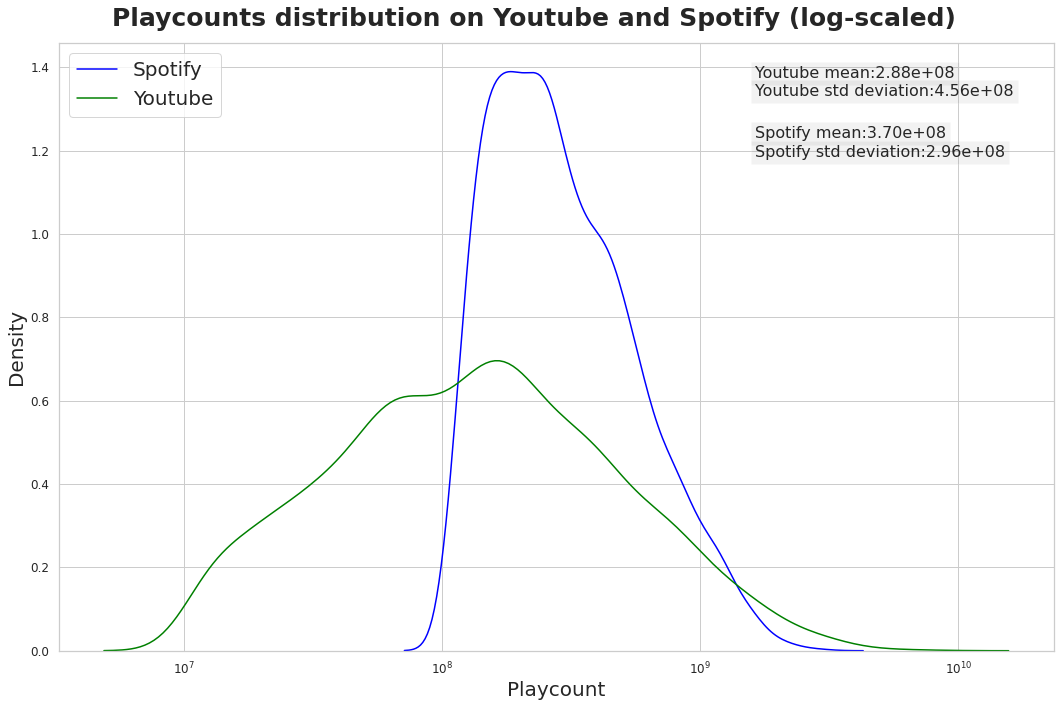

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.kdeplot(data=df, x="playcount", log_scale=True, ax=ax, color='blue', label="Spotify")
sns.kdeplot(data=df, x="view", ax=ax, log_scale=True, color='green', label="Youtube")
plt.legend(loc="upper left", prop={'size': 20})
ax.text(0.7, 0.95, 'Youtube {}:{:.2e}'.format("mean", df["view"].mean(axis=0)), size=16,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
ax.text(0.7, 0.92, 'Youtube {}:{:.2e}'.format("std deviation", df["view"].var(axis=0) ** 0.5), size=16,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))

ax.text(0.7, 0.85, 'Spotify {}:{:.2e}'.format("mean", df["playcount"].mean(axis=0)), size=16,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
ax.text(0.7, 0.82, 'Spotify {}:{:.2e}'.format("std deviation", df["playcount"].var(axis=0) ** 0.5), size=16,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))

ax.set_xlabel("Playcount")
fig.suptitle("Playcounts distribution on Youtube and Spotify (log-scaled)", fontsize=25, fontweight="bold")
ax.tick_params(labelsize=12)
ax.set_xlabel("Playcount", size=20)
ax.set_ylabel("Density", size=20)
fig.tight_layout()
save_plot("play_dist", fig)

#### Correlation between Spotify and Youtube playcounts

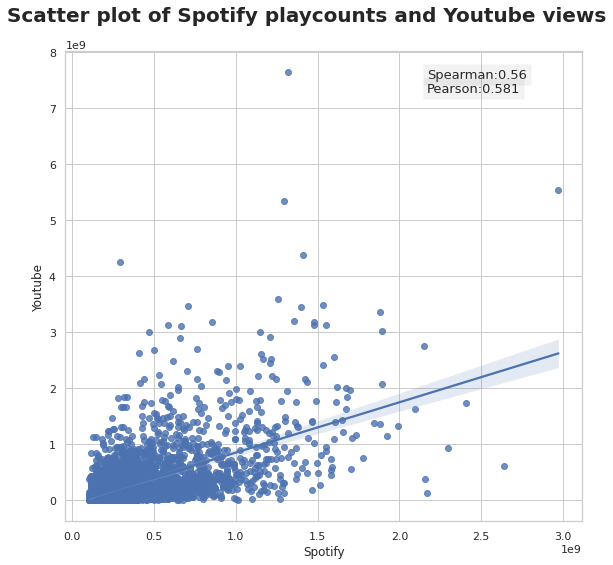

In [32]:
f, ax = plt.subplots(figsize=(8, 8))
sns.regplot(data=df, x="playcount", y="view", ax=ax)
ax.set_xlabel("Spotify")
ax.set_ylabel("Youtube")
f.suptitle("Scatter plot of Spotify playcounts and Youtube views", fontsize=20, fontweight="bold")
ax.text(0.7, 0.95, '{}:{}'.format("Spearman", round(df['playcount'].corr(df['view'], method='spearman'), 3)), size=13,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
ax.text(0.7, 0.92, '{}:{}'.format("Pearson", round(df['playcount'].corr(df['view'], method='pearson'), 3)), size=13,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
f.tight_layout()
save_plot("play_scat", f)

### Numeric audio feature analysis
In this section we will analyse the audio features of a track. These features are:
- danceability: measures how suitatble a track is for dancing
- speechiness: detects the presence of spoken words in a track
- valence: describes musical positiveness of a track
- energy: represents a perceptual measure of intensity and activity
- instrumentalness: predicts whether a track contains no vocals
- tempo: the overall estimated tempo of a track in beats per minute (BPM)
- loudness: the overall loudness of a track in decibels (dB)
- liveness: detects the presence of an audience in the recording
- duration: the duration of the track in seconds

#### Compute basic statistical index including mean, standard deviation, skewness and kurtosis

In [33]:
stat_dict = {}
for f in num_feature:
    stat_dict[f] = {}

for f in num_feature:
    mean = df[f].mean()
    stat_dict[f]['mean'] = mean
    variance = df[f].var(axis=0)
    stat_dict[f]['std deviation'] = variance ** 0.5
    skewness = df[f].skew(axis=0)
    stat_dict[f]['skewness'] = skewness
    kurtosis = df[f].kurt(axis=0)
    stat_dict[f]['kurtosis'] = kurtosis

#### Distribution of each audio feature

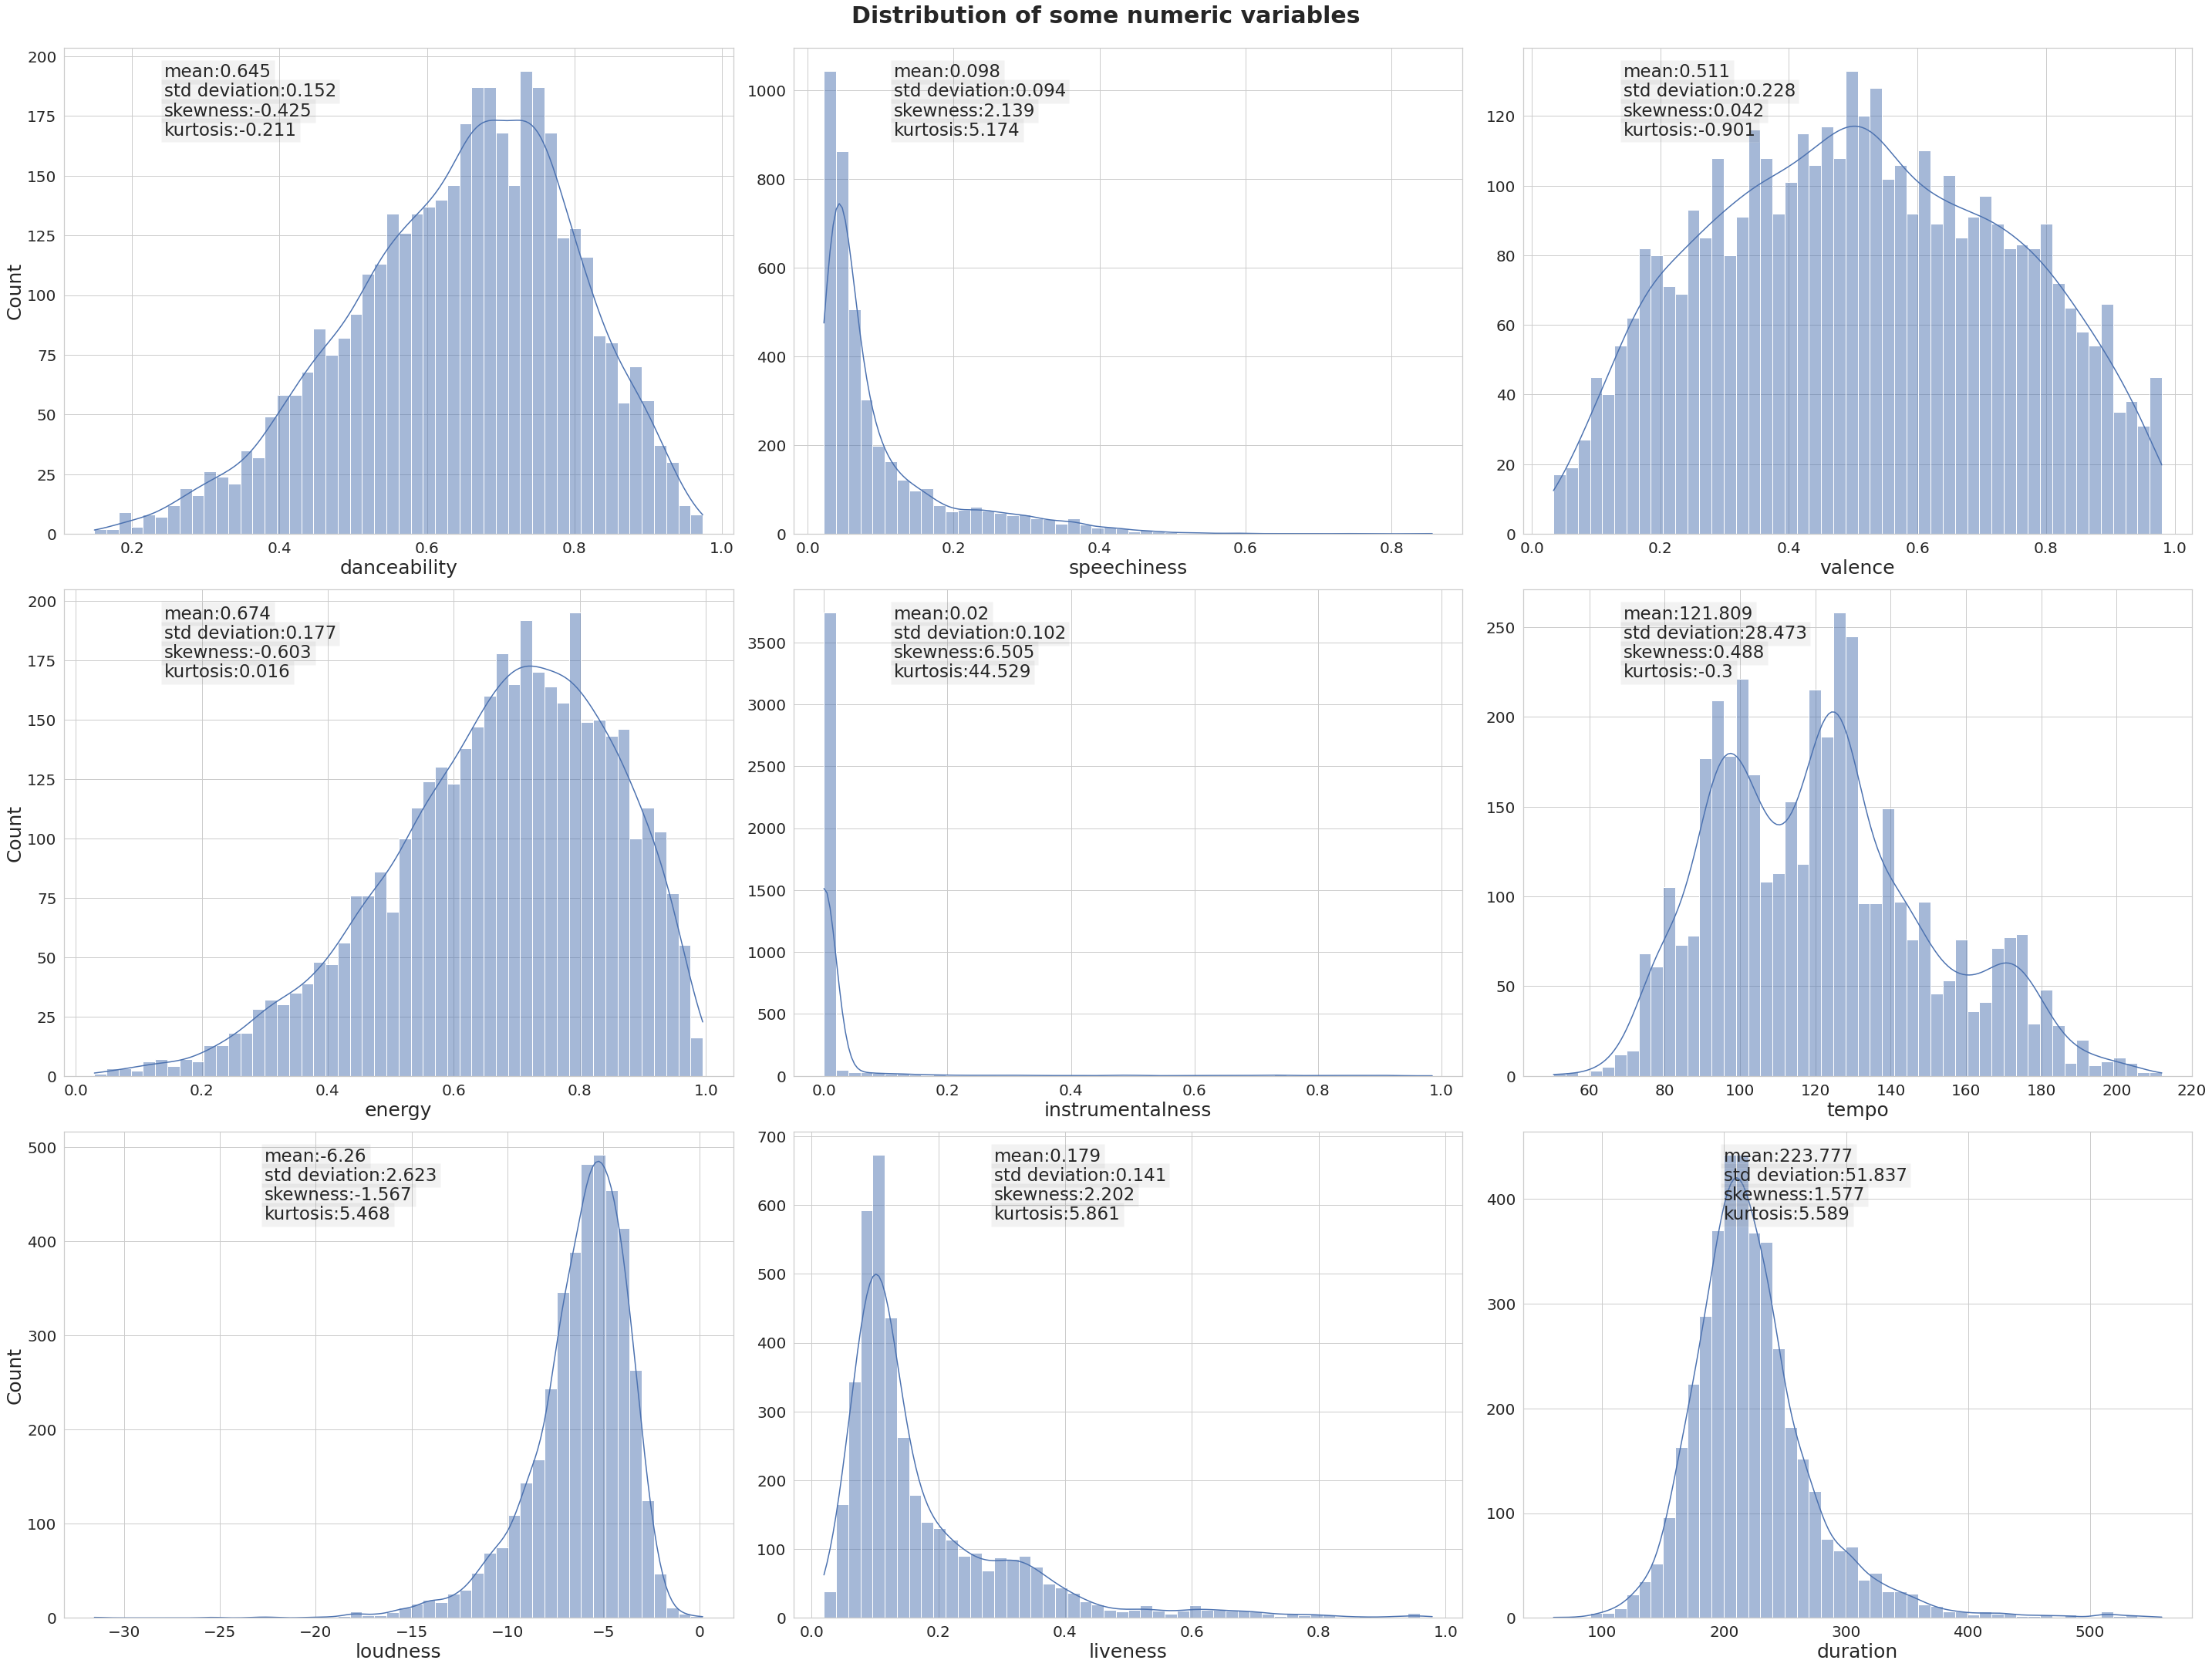

In [34]:
fig, ax = plt.subplots(3, 3, figsize=(40, 30))
for i in range(len(num_feature)):
    log_scale = False
    row = i % 3
    col = i // 3 
    for j, key in enumerate(stat_dict[num_feature[i]].keys()):
        text_y_pos = 0.95 - j * 0.04
        if row == 2: # move text to middle in the last row
            text_x_pos = 0.3
        else:
            text_x_pos = 0.15
        ax[row, col].text(text_x_pos, text_y_pos, '{}:{}'.format(key, round(stat_dict[num_feature[i]][key], 3)), size=23,
                          verticalalignment='center', transform=ax[row, col].transAxes, bbox=dict(facecolor='grey', alpha=0.1))
    sns.histplot(data=df, x=num_feature[i], ax=ax[row, col], kde=True, bins=50, log_scale=log_scale)
    if col == 0:
        ax[row, col].set_ylabel(ax[row, col].get_ylabel(), fontsize=25)
    else:
        ax[row, col].set_ylabel("")
    ax[row, col].set_xlabel(ax[row, col].get_xlabel(), fontsize=25)
    ax[row, col].tick_params(labelsize=20)
fig.suptitle("Distribution of some numeric variables", fontsize=30, fontweight="bold", y=1)
fig.tight_layout()
save_plot("num_var_dist", fig)


#### Correlation between each pair of audio features

##### Pearson

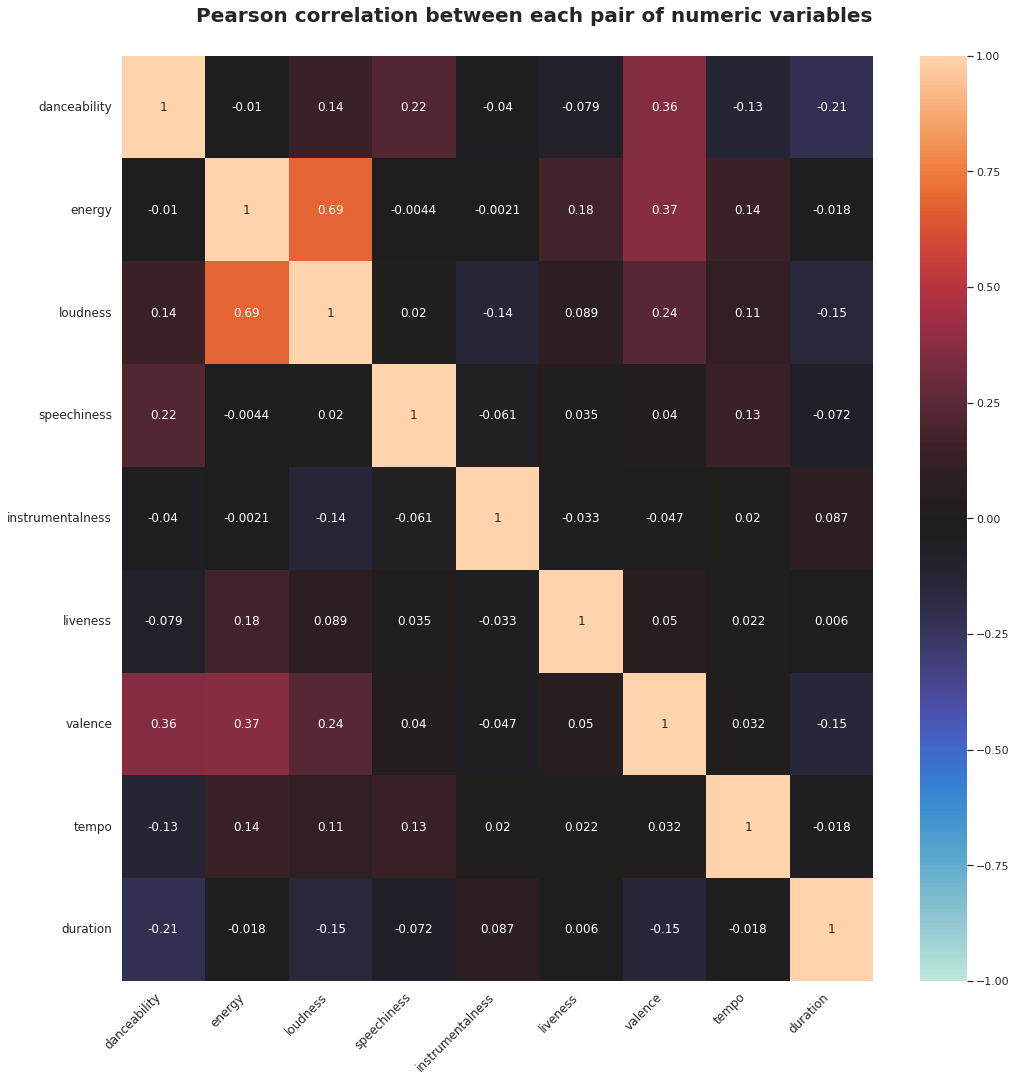

In [35]:
fig, ax = plt.subplots(figsize=(15, 15))
corr_df = df[num_feature].corr()
sns.heatmap(corr_df, annot=True, center=0, ax=ax, vmin=-1, vmax=1)
fig.suptitle("Pearson correlation between each pair of numeric variables", fontsize=20, y=1, fontweight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=12)
fig.tight_layout()
save_plot("pearson_corr_pair_num_var", fig)

##### Spearman

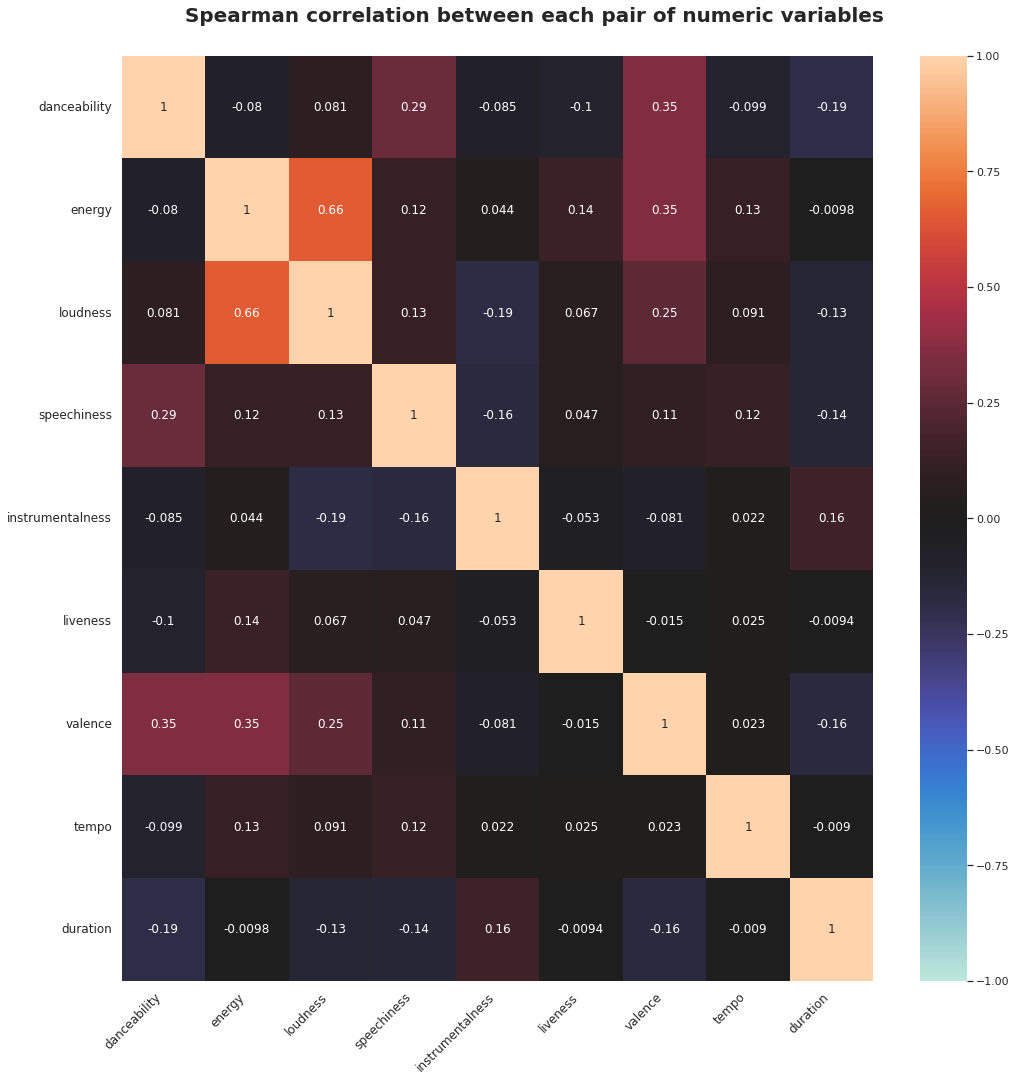

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))
corr_df = df[num_feature].corr('spearman')
sns.heatmap(corr_df, annot=True, center=0, ax=ax, vmin=-1, vmax=1)
fig.suptitle("Spearman correlation between each pair of numeric variables", fontsize=20, y=1, fontweight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=12)
fig.tight_layout()
save_plot("spearman_corr_pair_num_var", fig)

##### Scatter plot of the two most correlated features: loudness and energy

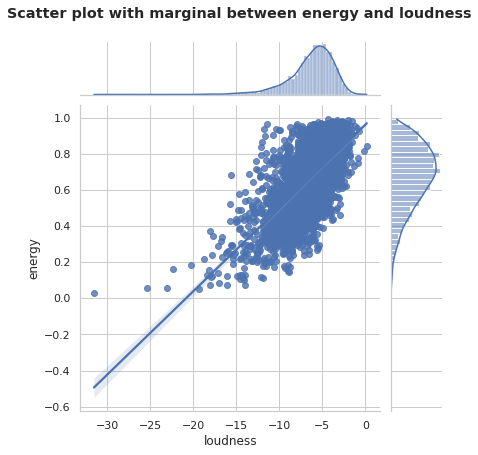

In [37]:
scat = sns.jointplot(data=df, x="loudness", y="energy", kind = 'reg')
plt.suptitle('Scatter plot with marginal between energy and loudness', y = 1.05, fontweight = 'bold')
save_plot("join_energy_loudness")

#### Correlation between each numeric variable and playcount, view

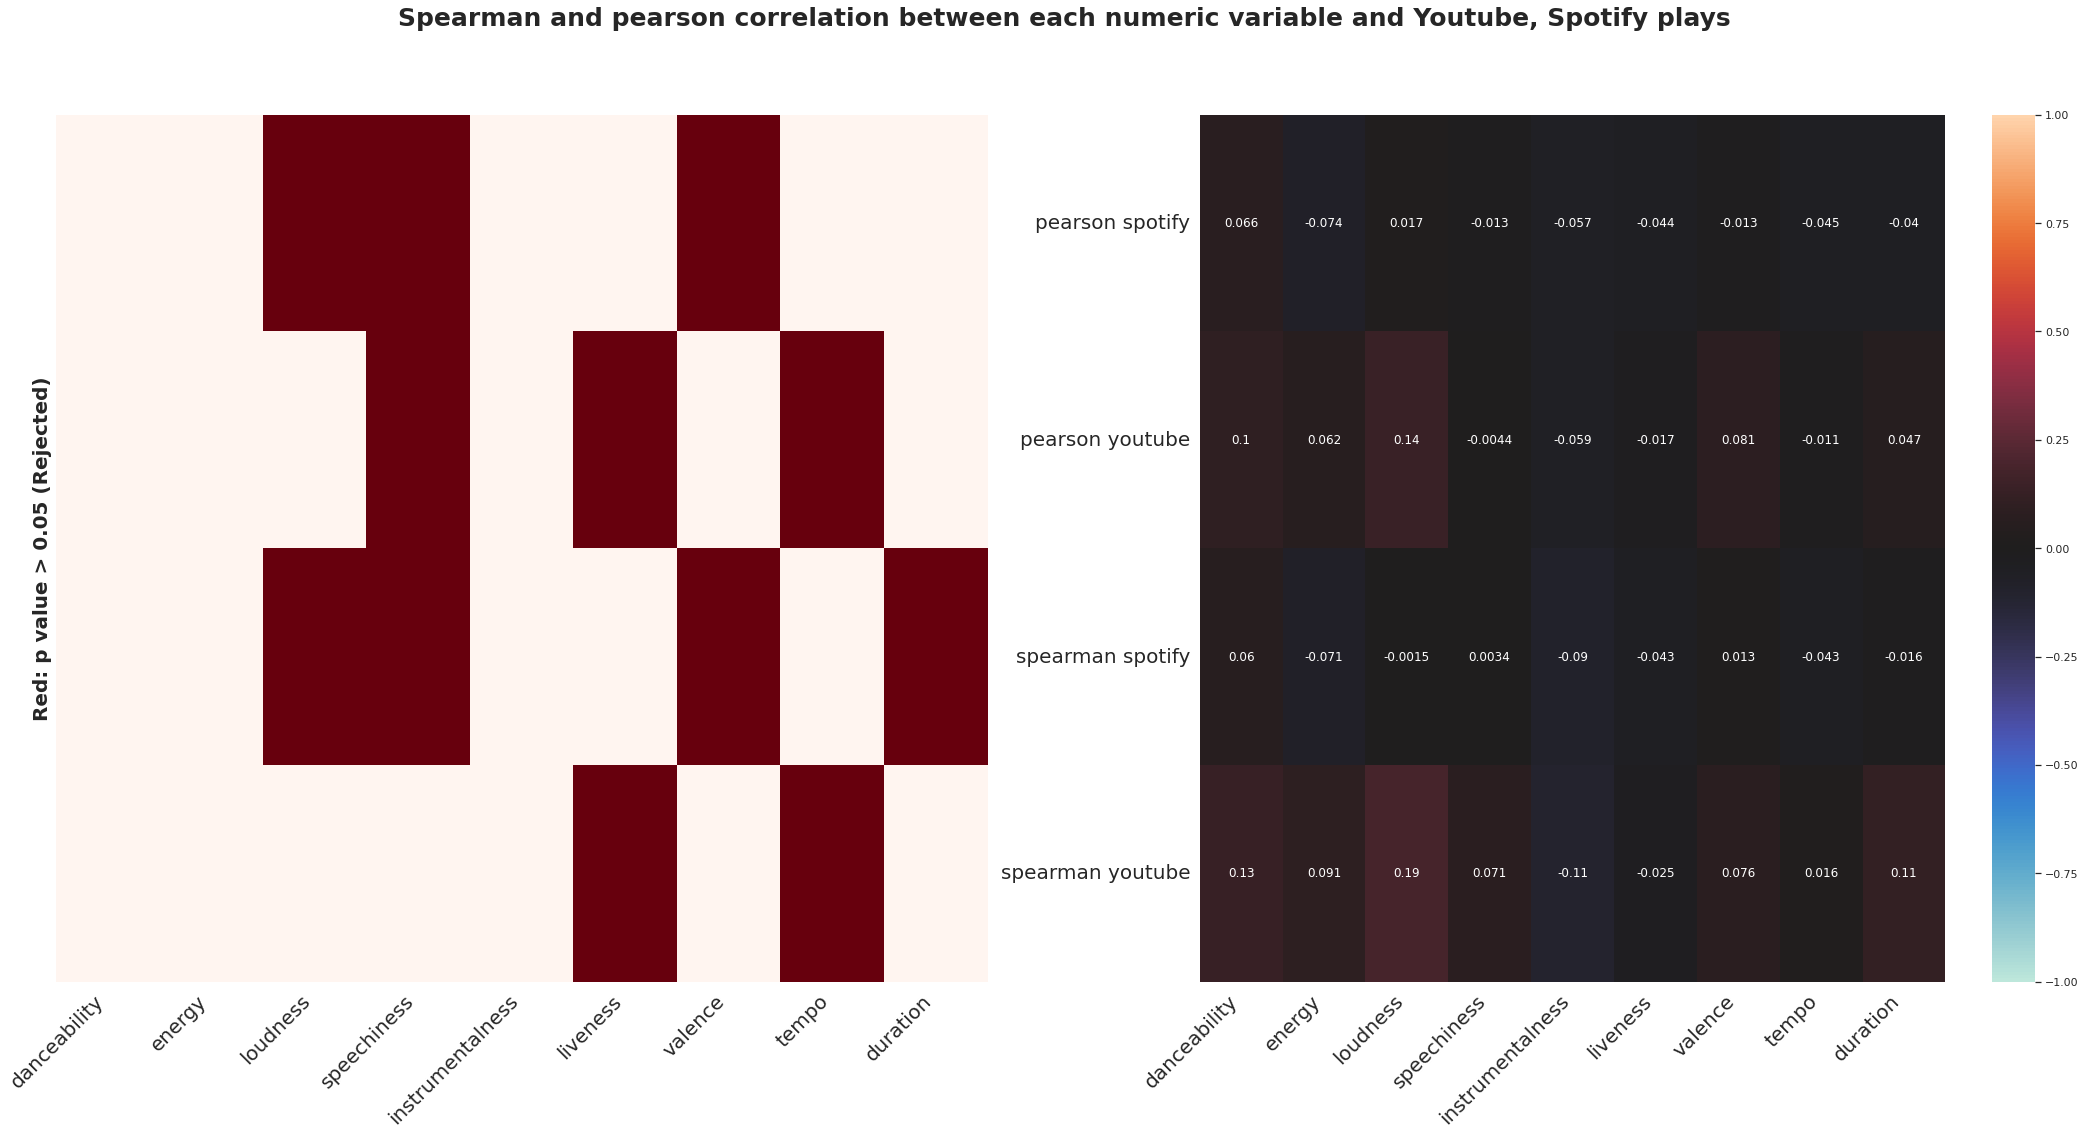

<Figure size 1440x1080 with 0 Axes>

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
corr, p = get_corr_matrix(df, num_feature, p=True)
sns.heatmap(p, cmap="Reds", ax=ax[0], cbar=False, yticklabels=[])
ax[0].set_ylabel("Red: p value > 0.05 (Rejected)", fontsize=20, fontweight='bold')
fig.suptitle("Spearman and pearson correlation between each numeric variable and Youtube, Spotify plays", fontsize=25, fontweight='bold', y=1.05)
plt.figure(figsize=(20, 15))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, center=0, ax=ax[1], yticklabels=["pearson spotify", "pearson youtube", "spearman spotify", "spearman youtube"])
# ax[0].tick_params(labelsize=20, rotation=30)
# ax[1].tick_params('x', labelsize=20, rotation=30)
# ax[1].tick_params('y', labelsize=20, rotation=30)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right', fontsize=20)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right', fontsize=20)
ax[1].set_ylabel("")
ax[1].tick_params('y', labelsize=20, rotation=0)
fig.tight_layout()
save_plot("corr", fig)

### Categorical features analysis
In this section we will perform analysis on each categorical feature excluding genre. There will be another section dedicated to genre analysis

#### Explicit
Explicit shows whether a song has explicit lyrics. Possible values are 'Yes' and 'No'

##### How many songs have explicit lyrics? And how many do not?

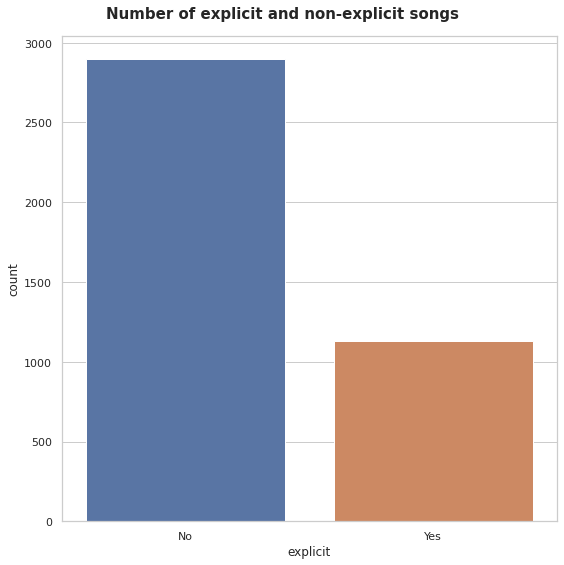

In [39]:
plt.figure(figsize=(8,8))
sns.countplot(x="explicit", data=df, order=df['explicit'].value_counts().index)
plt.suptitle("Number of explicit and non-explicit songs", fontsize=15, fontweight='bold')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
save_plot("explicit_count")

##### Scatter plot of view and playcount corresponding to the "explicit" variable

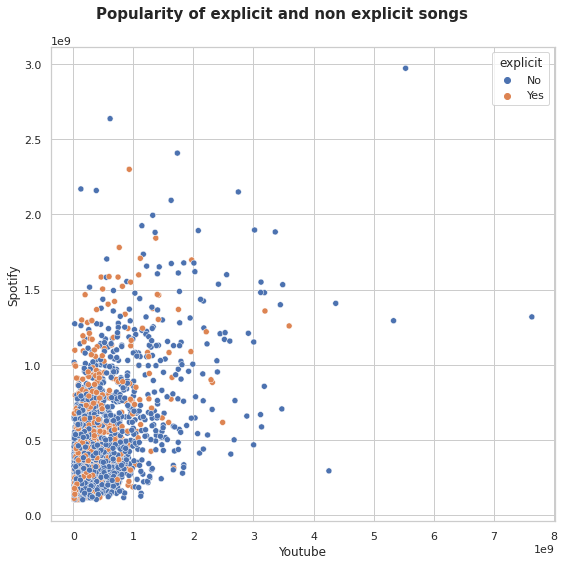

In [40]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x="view", y="playcount", hue='explicit', ax=ax)
ax.set_ylabel("Spotify")
ax.set_xlabel("Youtube")
f.suptitle("Popularity of explicit and non explicit songs", fontsize=15, fontweight='bold')
f.tight_layout()
save_plot("play_explicit_scat", f)

##### Does having explicit lyrics affect a song's popularity?
We will use z-test to see if there is any difference between the mean between explicit and non-eplicit songs

In [41]:
explicit = df[df["explicit"] == 'Yes']
non_explicit = df[df["explicit"] == 'No']

p_playcount = ztest(explicit["playcount"], non_explicit["playcount"])[1]
p_view = ztest(explicit["view"], non_explicit["view"])[1]
print(f"Spotify playcount p value: {p_playcount}")
print(f"Youtube playcount p value: {p_view}")

Spotify playcount p value: 0.3156528855653319
Youtube playcount p value: 5.505721110800131e-07


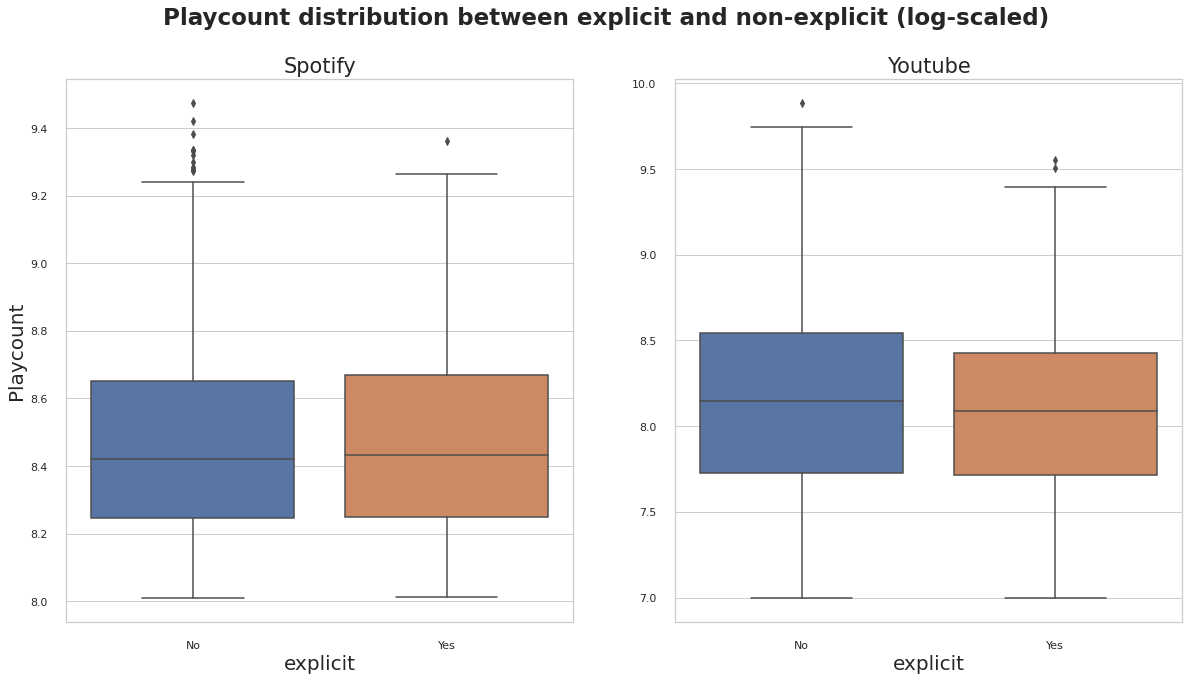

In [42]:
df_log = df.copy()
df_log["playcount"] = df_log["playcount"].apply(log10)
df_log["view"] = df_log["view"].apply(log10)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot(x="explicit", y="playcount", data=df_log, ax=ax[0])
sns.boxplot(x="explicit", y="view", data=df_log, ax=ax[1])
ax[0].set_ylabel("Playcount", fontsize=20)
ax[0].tick_params(size=15)
ax[0].set_xlabel("explicit", fontsize=20)
ax[0].set_title("Spotify", fontsize=21)
ax[1].set_ylabel("")
ax[1].tick_params(size=15)
ax[1].set_xlabel("explicit", fontsize=20)
ax[1].set_title("Youtube", fontsize=21)
fig.suptitle("Playcount distribution between explicit and non-explicit (log-scaled)", fontsize=23, fontweight="bold")
save_plot("explicit_test", fig)

#### Mode
This feature specifies the mode of a song. A song can be in "major" or "minor"

##### How many songs are in major and minor

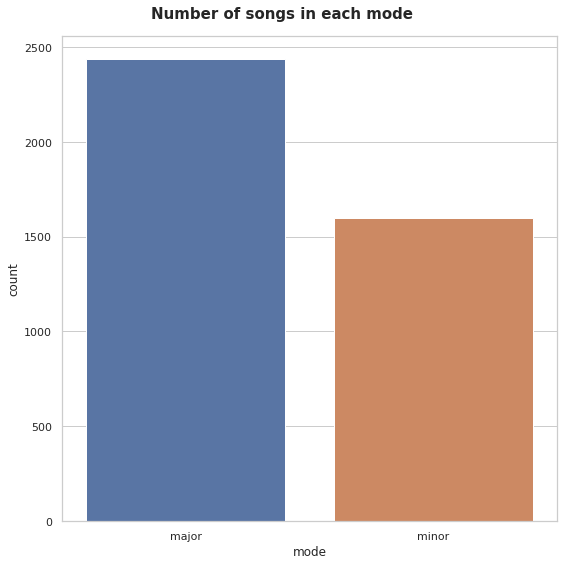

In [43]:
plt.figure(figsize=(8,8))
sns.countplot(x="mode", data=df, order=df['mode'].value_counts().index)
plt.suptitle("Number of songs in each mode", fontsize=15, fontweight='bold')
plt.tight_layout()
save_plot("mode_count")

##### Popularity of songs in major and minor

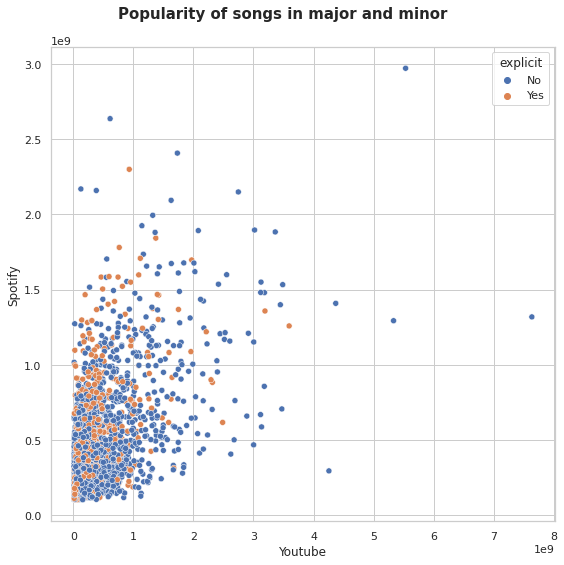

In [44]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x="view", y="playcount", hue='explicit', ax=ax)
ax.set_ylabel("Spotify")
ax.set_xlabel("Youtube")
f.suptitle("Popularity of songs in major and minor", fontsize=15, fontweight='bold')
f.tight_layout()
save_plot("play_mode_scat", f)

##### Popularity in each playcount bins

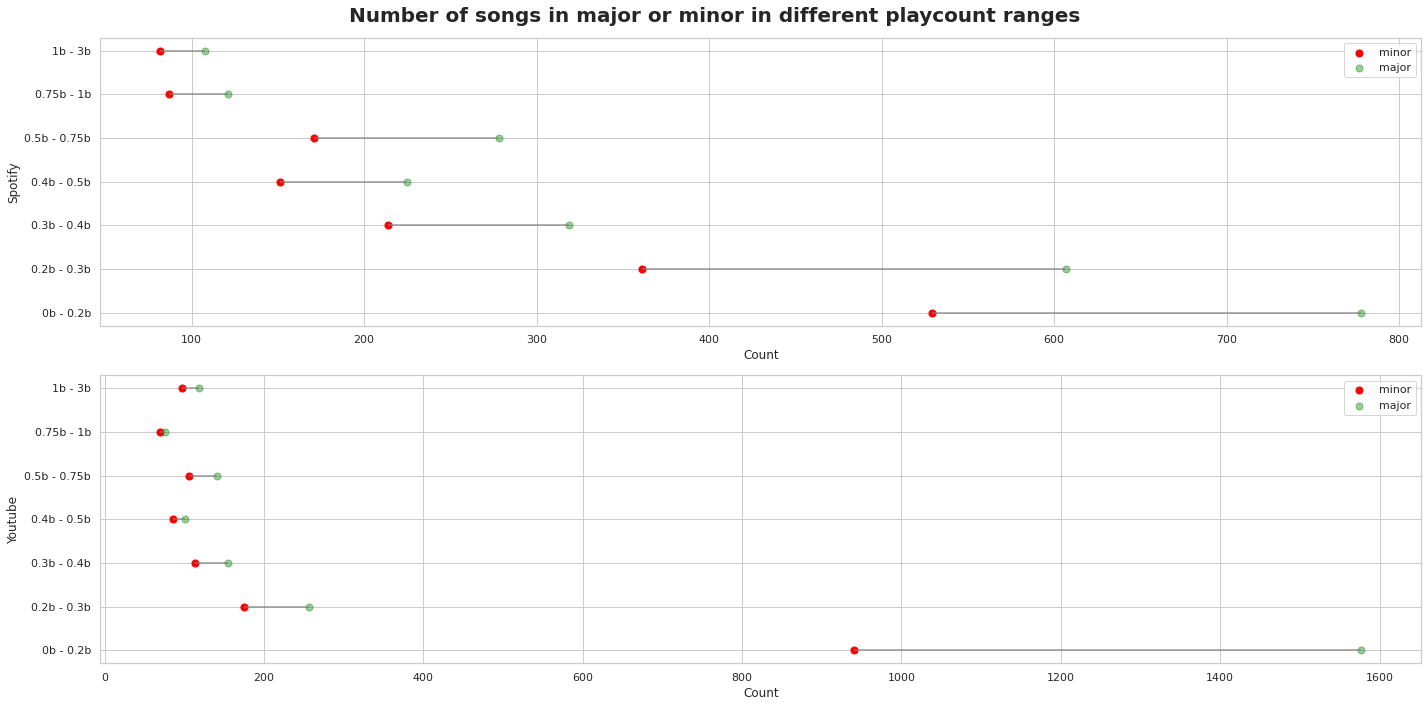

In [45]:
bins = pd.IntervalIndex.from_tuples(
    [(0, 2e8), (2e8, 3e8), (3e8, 4e8), (4e8, 5e8), (5e8, 7.5e8), (7.5e8, 1e9), (1e9, 3e9)])
def plot_lollipop(pop_type, ax):
    df_lolli = df.copy()
    df_lolli["bins"] = pd.cut(df_lolli[pop_type], bins)
    pop_dist_0 = df_lolli[df_lolli["mode"] == "minor"].groupby("bins")[[pop_type]].count()
    pop_dist_1 = df_lolli[df_lolli["mode"] == "major"].groupby("bins")[[pop_type]].count()
    pop_dist = pd.DataFrame()
    pop_dist["minor"] = pop_dist_0[pop_type]
    pop_dist["major"] = pop_dist_1[pop_type]
    pop_dist = pop_dist.reset_index()
    my_range = range(1, len(pop_dist.index)+1)

    # The horizontal plot is made using the hline function
    ax.hlines(y=my_range, xmin=pop_dist['minor'],
            xmax=pop_dist['major'], color='grey', alpha=0.6, lw=2)
    ax.scatter(pop_dist['minor'], my_range,
                color='red', alpha=1, label='minor', s=50)
    ax.scatter(pop_dist['major'], my_range,
                color='green', alpha=0.4, label='major', s=50)
    ax.legend()

    # Add title and axis names
    group_name = [
        "0b - 0.2b",
        "0.2b - 0.3b",
        "0.3b - 0.4b",
        "0.4b - 0.5b",
        "0.5b - 0.75b",
        "0.75b - 1b",
        "1b - 3b"
    ]
    ax.set_yticks(my_range, group_name)
    ax.set_xlabel('Count')
    if pop_type == "playcount":
        ax.set_ylabel('Spotify')
    elif pop_type == "view":
        ax.set_ylabel('Youtube')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
plot_lollipop("playcount", ax[0])
plot_lollipop("view", ax[1])
fig.suptitle("Number of songs in major or minor in different playcount ranges", fontsize=20, fontweight='bold')
# Show the graph
fig.tight_layout()
save_plot("lollipop")

##### Conduct hypothesis testing for this feature

In [46]:
minor = df[df["mode"] == "minor"]
major = df[df["mode"] == "major"]
def log10(x):
    return log(x, 10)
df_log = df.copy()
df_log["playcount"] = df_log["playcount"].apply(log10)
df_log["view"] = df_log["view"].apply(log10)
p_playcount = ztest(minor["playcount"], major["playcount"])[1]
p_view = ztest(minor["view"], major["view"])[1]
print(f"Spotify playcount p value: {p_playcount}")
print(f"YouTube view p value: {p_view}")

Spotify playcount p value: 0.408930756678614
YouTube view p value: 0.0037220602532270423


Text(0.5, 0.98, 'Playcount distribution between different mode (log-scaled)')

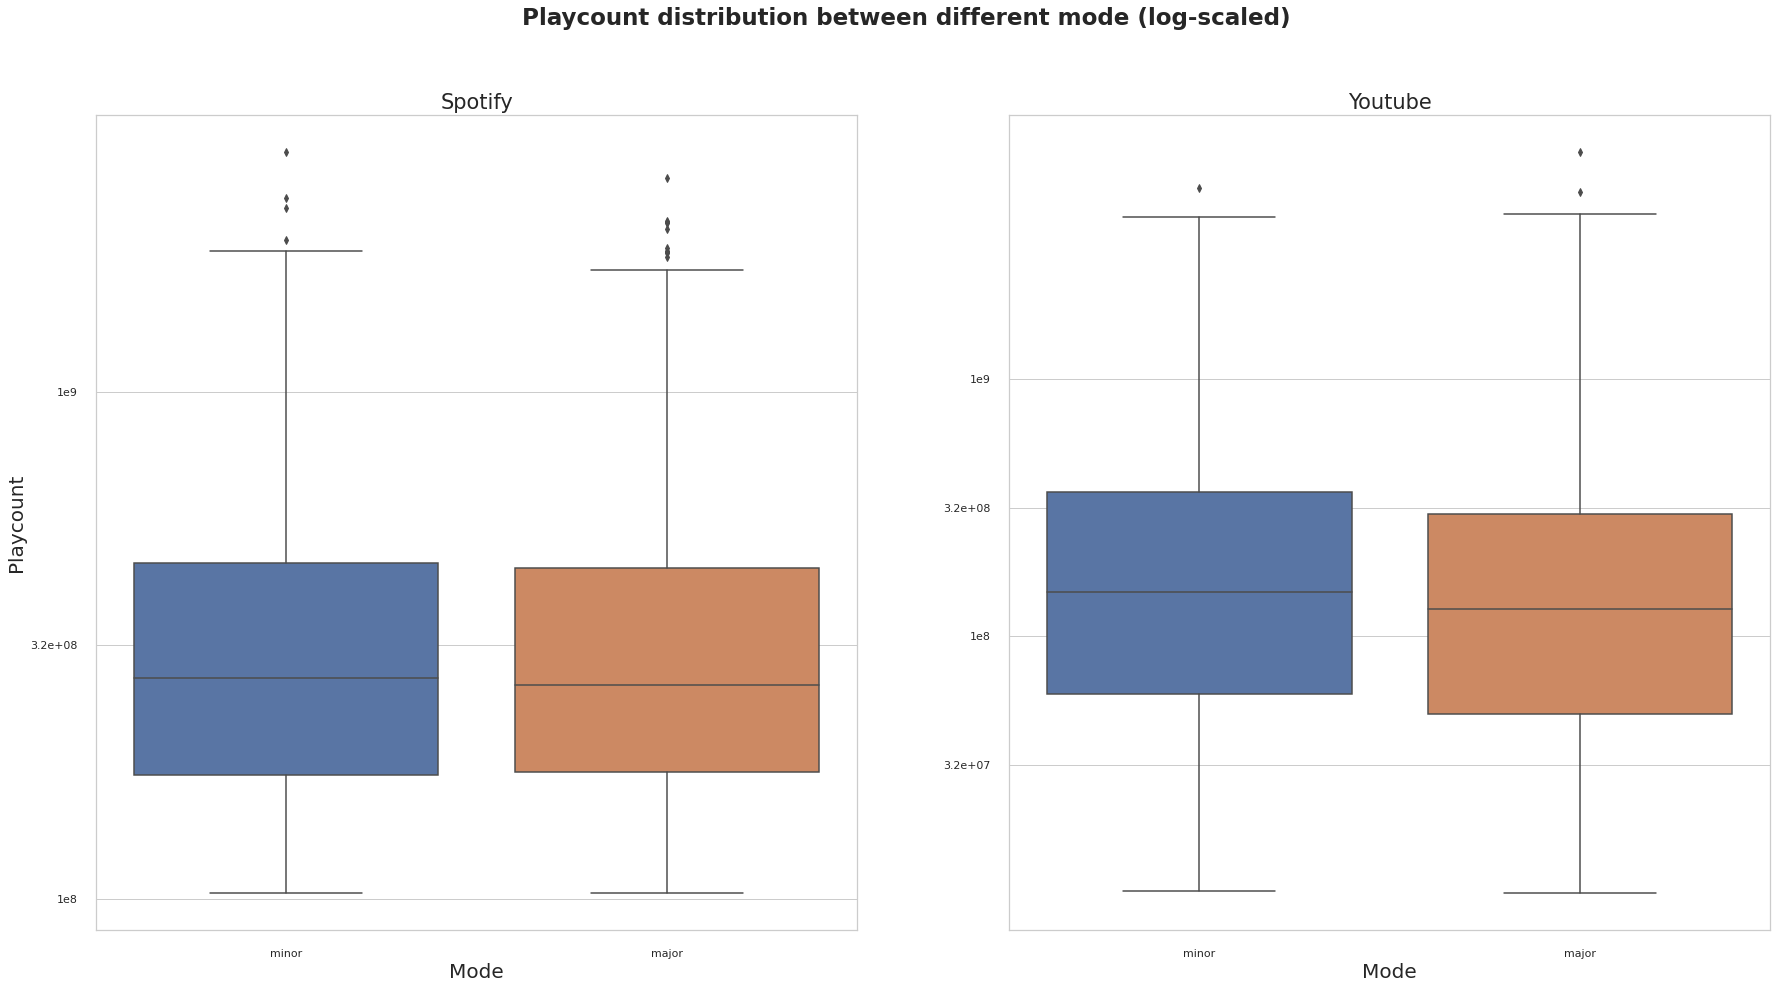

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
sns.boxplot(x="mode", y="playcount", data=df_log, ax=ax[0])
sns.boxplot(x="mode", y="view", data=df_log, ax=ax[1])
ax[0].set_ylabel("Playcount", fontsize=20)
ax[0].set_yticks([8, 8.5, 9], ["1e8", f"{10**8.5:.1e}" ,"1e9"])
ax[0].tick_params(size=15)
ax[0].set_xlabel("Mode", fontsize=20)
ax[0].set_title("Spotify", fontsize=21)
ax[1].set_ylabel("")
ax[1].set_yticks([7.5, 8, 8.5, 9], [f"{10**7.5:.1e}", "1e8", f"{10**8.5:.1e}" ,"1e9"])
ax[1].tick_params(size=15)
ax[1].set_xlabel("Mode", fontsize=20)
ax[1].set_title("Youtube", fontsize=21)
fig.suptitle("Playcount distribution between different mode (log-scaled)", fontsize=23, fontweight="bold")


#### Key
This feature specifies the key a track is in (for example C, D, etc)

##### How many songs are there in each keys?

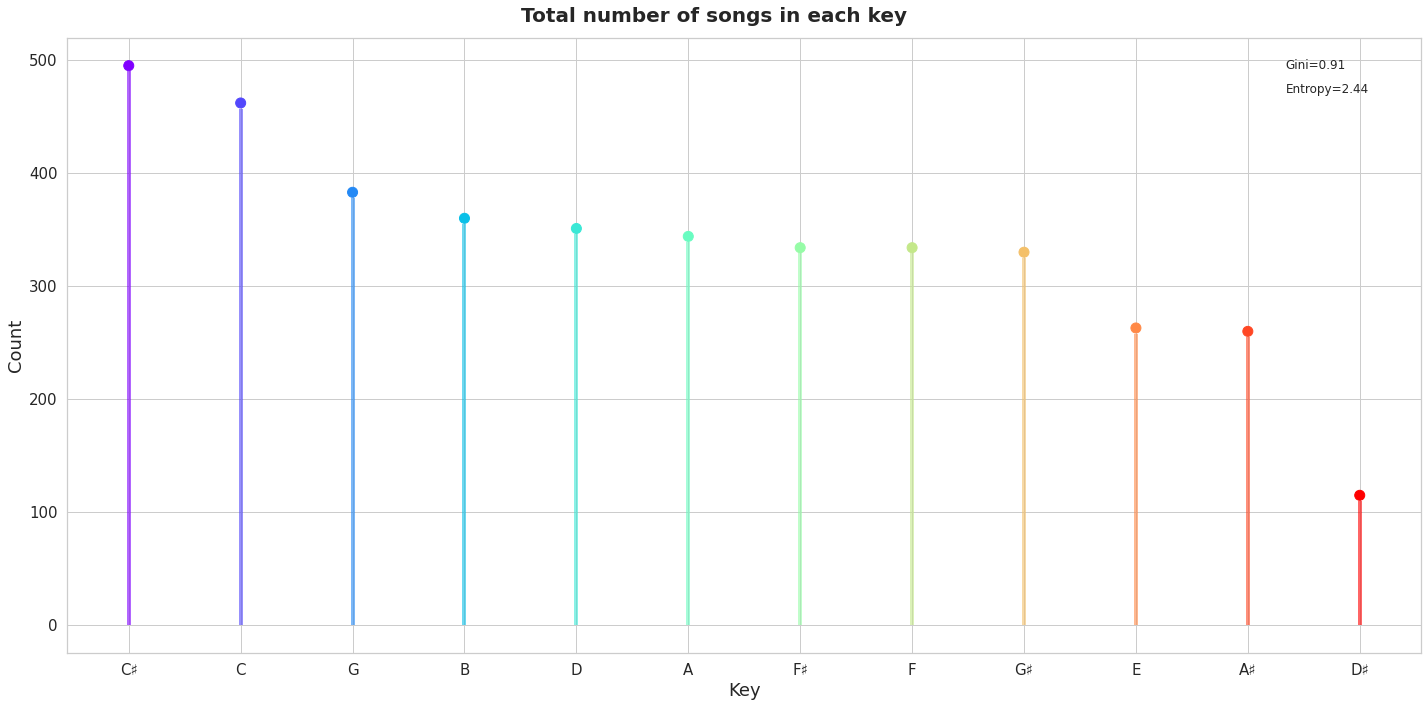

In [48]:
fig, ax = plt.subplots(figsize=(20, 10))
key_count = df['key'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(key_count)))
my_range = np.arange(len(key_count))
ax.vlines(x=my_range, ymin=0, ymax=key_count - 5,
          alpha=0.6, linewidth=4, colors=colors)
ax.scatter(x=my_range, y=key_count, s=100, c=colors)
ax.set_xticks(my_range, key_count.index)
ax.text(0.9, 0.95, 'Gini={}'.format(
    round(gini(df, 'key'), 2)), transform=ax.transAxes)
ax.text(0.9, 0.91, 'Entropy={}'.format(
    round(entropy(df, 'key'), 2)), transform=ax.transAxes)
fig.suptitle("Total number of songs in each key", fontsize=20, fontweight="bold")
ax.tick_params(labelsize=15)
ax.set_xlabel("Key", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
fig.tight_layout()
save_plot("key_lolli", fig)


##### Average playcount in each key

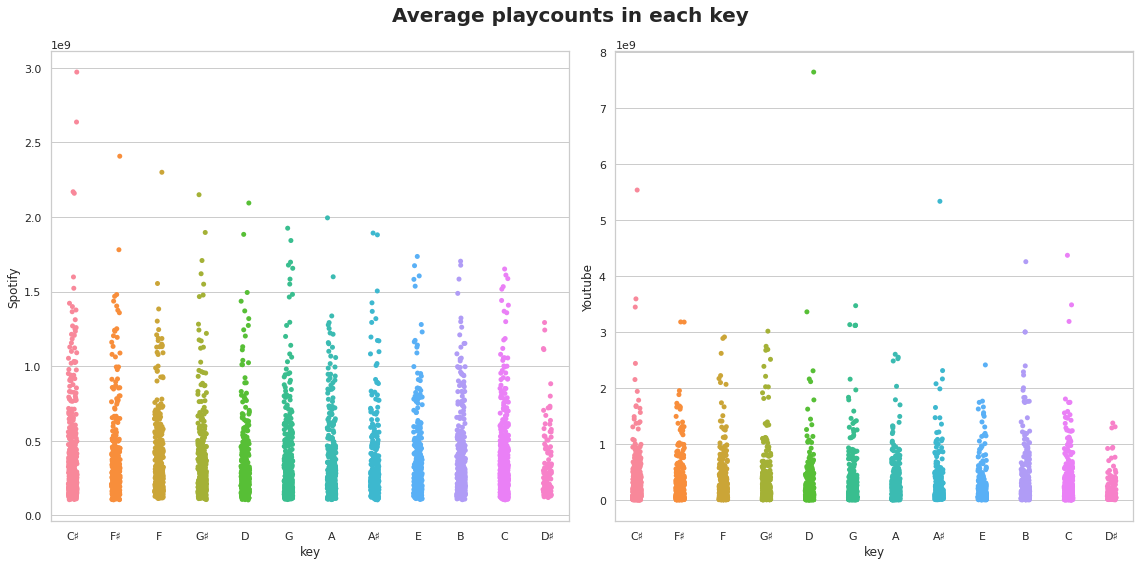

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.stripplot(x="key", y="playcount", data=df, ax=ax[0])
sns.stripplot(x="key", y="view", data=df, ax=ax[1])
ax[0].set_ylabel("Spotify")
ax[1].set_ylabel("Youtube")
fig.suptitle("Average playcounts in each key", fontsize=20, fontweight='bold')
fig.tight_layout()
save_plot("play_strip", fig)

#### Time signature
This feature specifies how many beats there are in each bar

##### Songs count in each time signature

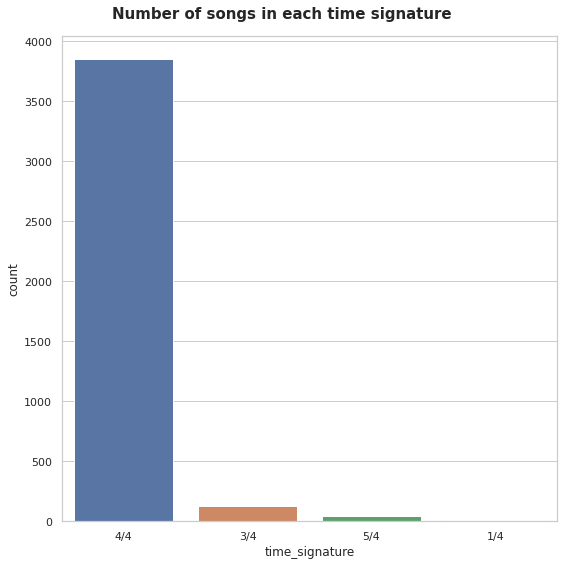

In [50]:
plt.figure(figsize=(8,8))
sns.countplot(x="time_signature", data=df,
              order=df['time_signature'].value_counts().index)
plt.suptitle("Number of songs in each time signature", fontsize=15, fontweight='bold')
plt.tight_layout()
save_plot("time_sig_count")

##### Popularity of songs in each time signature

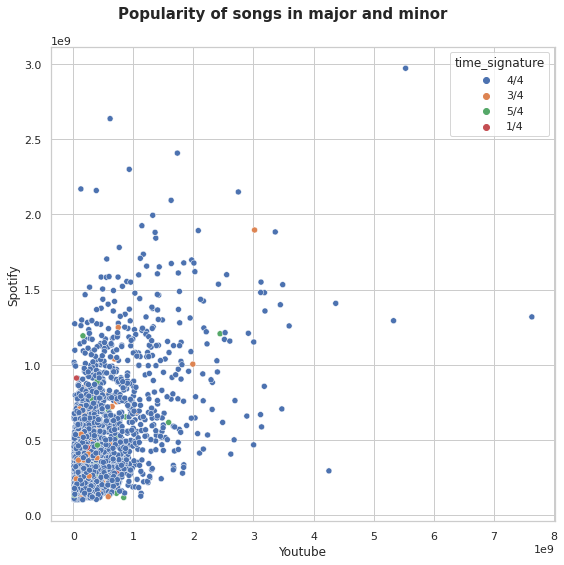

In [51]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x="view", y="playcount", hue='time_signature', ax=ax)
ax.set_ylabel("Spotify")
ax.set_xlabel("Youtube")
f.suptitle("Popularity of songs in major and minor", fontsize=15, fontweight='bold')
f.tight_layout()
save_plot("play_mode_scat", f)

### Genre analysis

#### The count of each genre

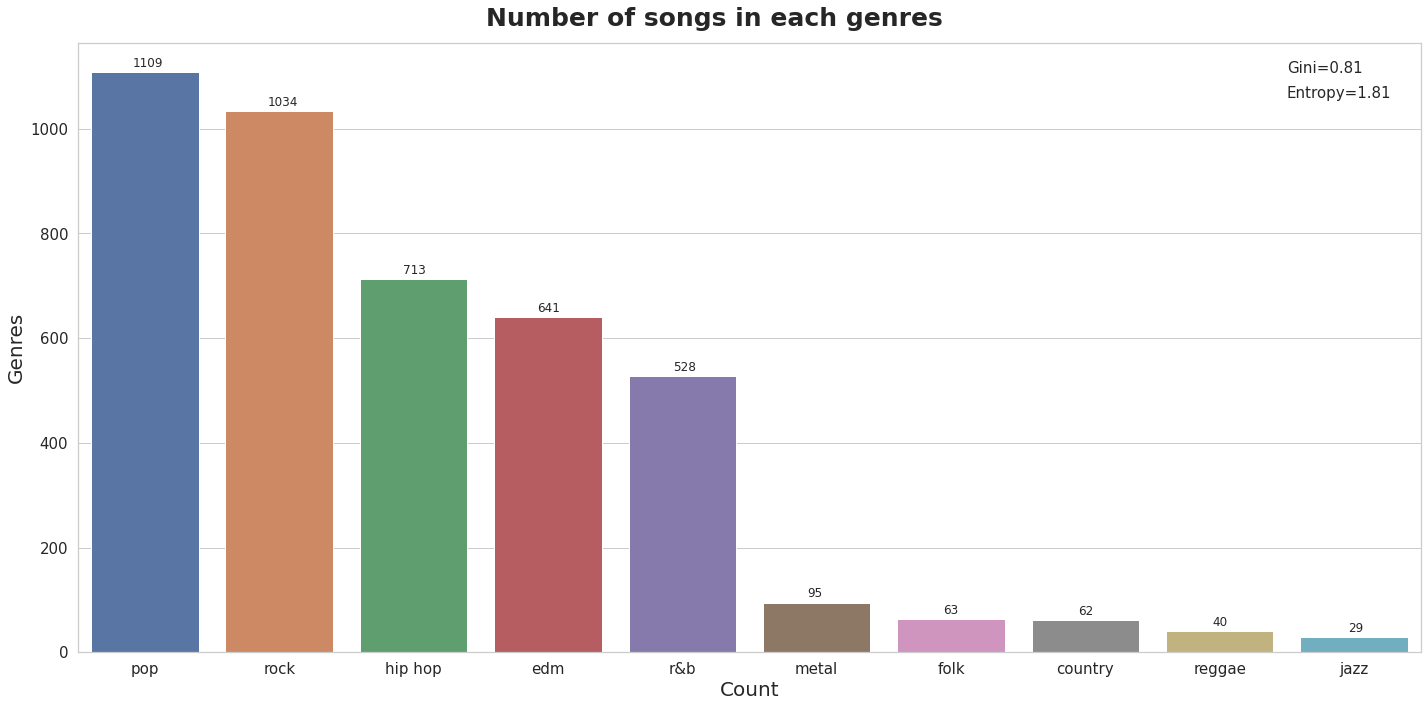

In [52]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(x="genres", data=df_with_genre,
              order=df_with_genre['genres'].value_counts(dropna=True).index, ax=ax)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() *
                1.005 + 0.31, p.get_height() + 10))
fig.suptitle("Number of songs in each genres", fontsize=25, fontweight="bold")
ax.text(0.9, 0.95, 'Gini={}'.format(
    round(gini(df_with_genre, 'genres'), 2)), transform=ax.transAxes, size=15)
ax.text(0.9, 0.91, 'Entropy={}'.format(
    round(entropy(df_with_genre, 'genres'), 2)), transform=ax.transAxes, size=15)
ax.set_ylabel("Genres", fontsize=20)
ax.set_xlabel("Count", fontsize=20)
ax.tick_params(labelsize=15)
fig.tight_layout()
save_plot("genre_count", fig)

#### Playcount and view distribution with respect to each genre

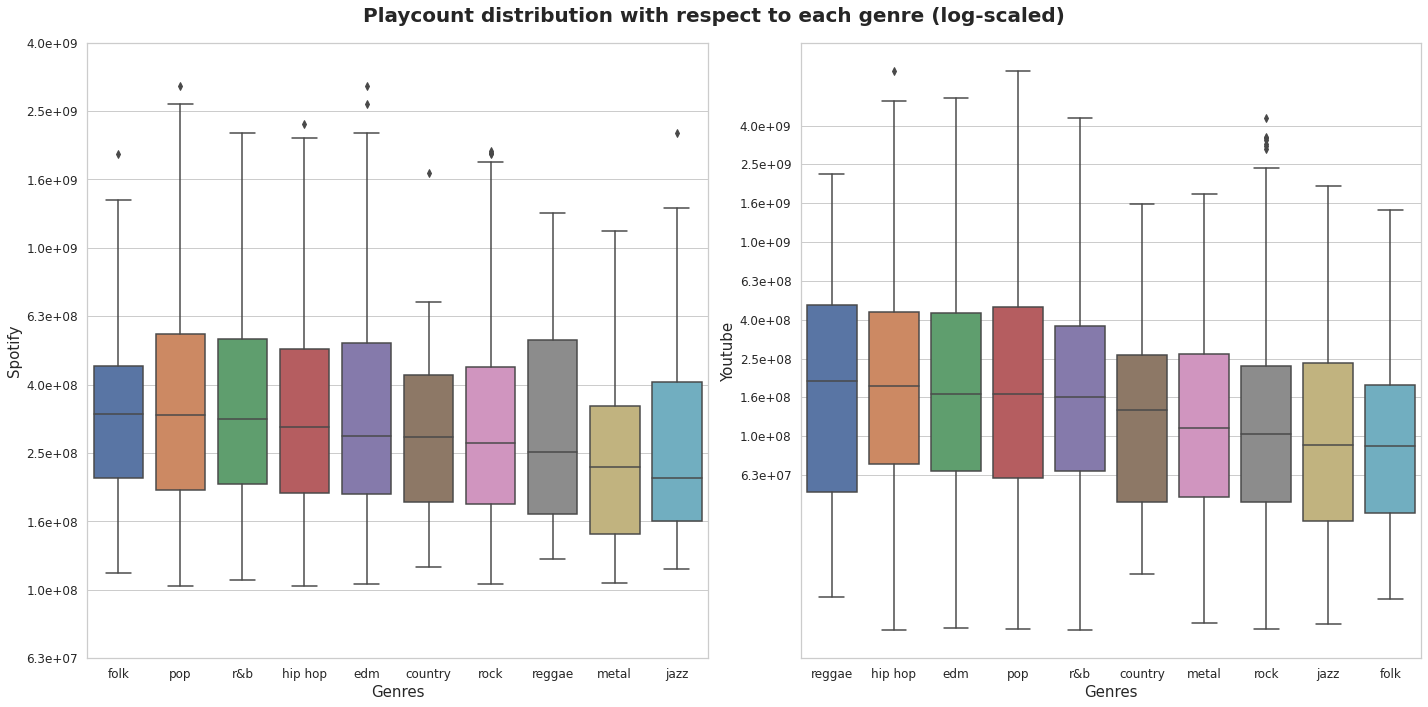

In [53]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
df_log = df_with_genre.copy()
df_log["playcount"] = df_log["playcount"].apply(log10)
df_log["view"] = df_log["view"].apply(log10)
sns.boxplot(x="genres", y="playcount", data=df_log, ax = ax[0], order=df_log.groupby("genres")["playcount"].median().sort_values(ascending=False).index)
sns.boxplot(x="genres", y="view", data=df_log, ax = ax[1], order=df_log.groupby("genres")["view"].median().sort_values(ascending=False).index)
fig.suptitle("Playcount distribution with respect to each genre (log-scaled)", fontsize=20, fontweight='bold')
for a in ax:
    ylabel = a.get_ylabel()
    if ylabel == 'playcount':
        ylabel = "Spotify"
    elif ylabel == 'view':
        ylabel = "Youtube"
    a.set_ylabel(ylabel, fontsize=15)
    a.set_xlabel("Genres", fontsize=15)
    a.set_yticks(ax[0].get_yticks(), [f"{10**ele:.1e}" for ele in ax[0].get_yticks()])
    a.tick_params(labelsize=12)
fig.tight_layout()
save_plot("play_dist_genre", fig)

#### Which combinations of genres appear frequently?

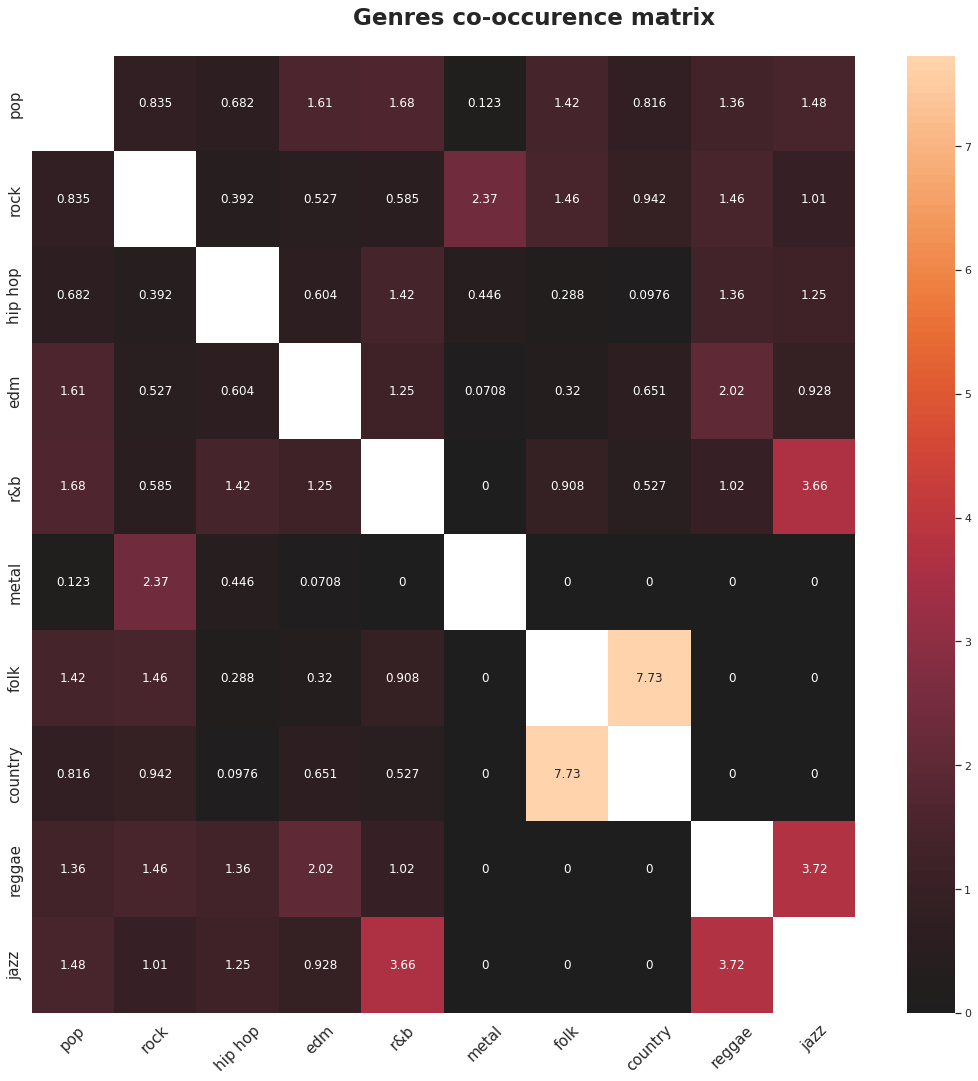

In [54]:
m = ConfusionMatrix(list(df_with_genre["genres"].value_counts().index))
count = df_with_genre["genres"].value_counts()
for genre in count.index:
    m.update_diag(genre, count[genre])

for i, row in df_with_genre.dropna().iterrows():
    if i == 0:
        prev_track = row["track_id"]
        curr_list = [row["genres"]]
        continue
    curr_track = row["track_id"]
    if prev_track != curr_track:
        for pair in findsubsets(curr_list, 2):
            m.increment(pair)
        prev_track = curr_track
        curr_list = [row["genres"]]
    else:
        curr_list.append(row["genres"])
m.normalize()
m.reset_diag()

mask = np.zeros_like(m.matrix)
np.fill_diagonal(mask, 1)
# mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(m.matrix, annot=True, center=0, fmt=".3g", mask=mask,
            xticklabels=m.ele, yticklabels=m.ele, ax=ax)
fig.suptitle("Genres co-occurence matrix", fontsize=23, fontweight="bold", y=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.tick_params(labelsize=15)
fig.tight_layout()
save_plot("genre_cooc")

#### Distribution of some numeric features with respect to each genre

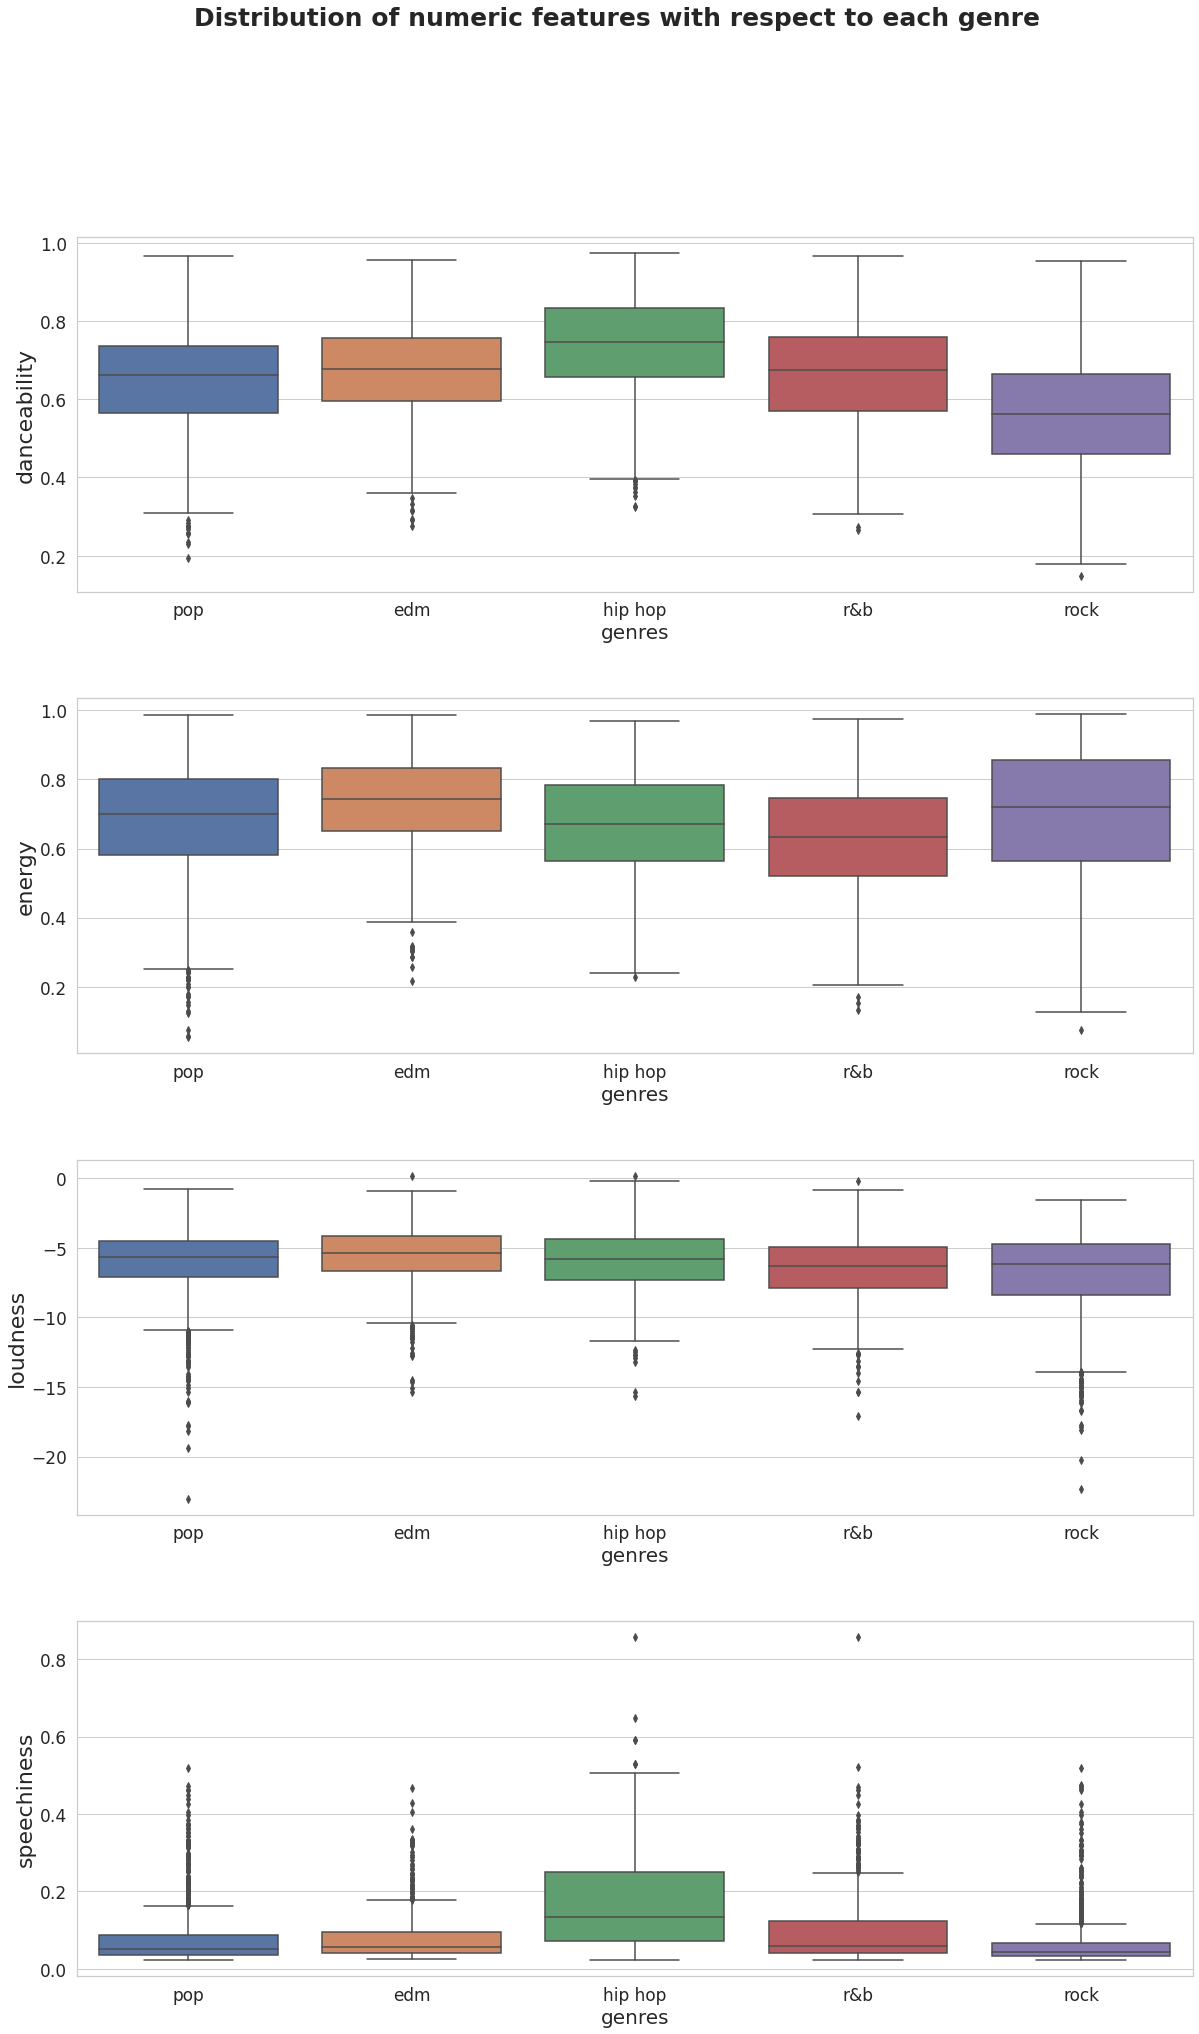

In [55]:
def big_genre(x):
    if x in ['pop', 'rock', 'hip hop', 'edm', 'r&b']:
        return True
    else:
        return False
df_with_genre_sub = df_with_genre[df_with_genre["genres"].apply(big_genre)]
no_instru = num_feature.copy()
no_instru.remove("instrumentalness")
fig, ax = plt.subplots(len(no_instru) // 2, 1, figsize=(20, 8 * (len(no_instru) // 2)))
for i in range(len(no_instru) // 2):
    sns.boxplot(x="genres", y=no_instru[i], data=df_with_genre_sub,  ax=ax[i])
    ax[i].tick_params(labelsize=17)
    ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=22)
    ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=22)
    ax[i].set_xlabel(ax[i].get_xlabel(), fontsize=20)
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Distribution of numeric features with respect to each genre', fontsize=25, fontweight='bold')
# fig.tight_layout()
save_plot("num_var_genre_dist_1", fig)

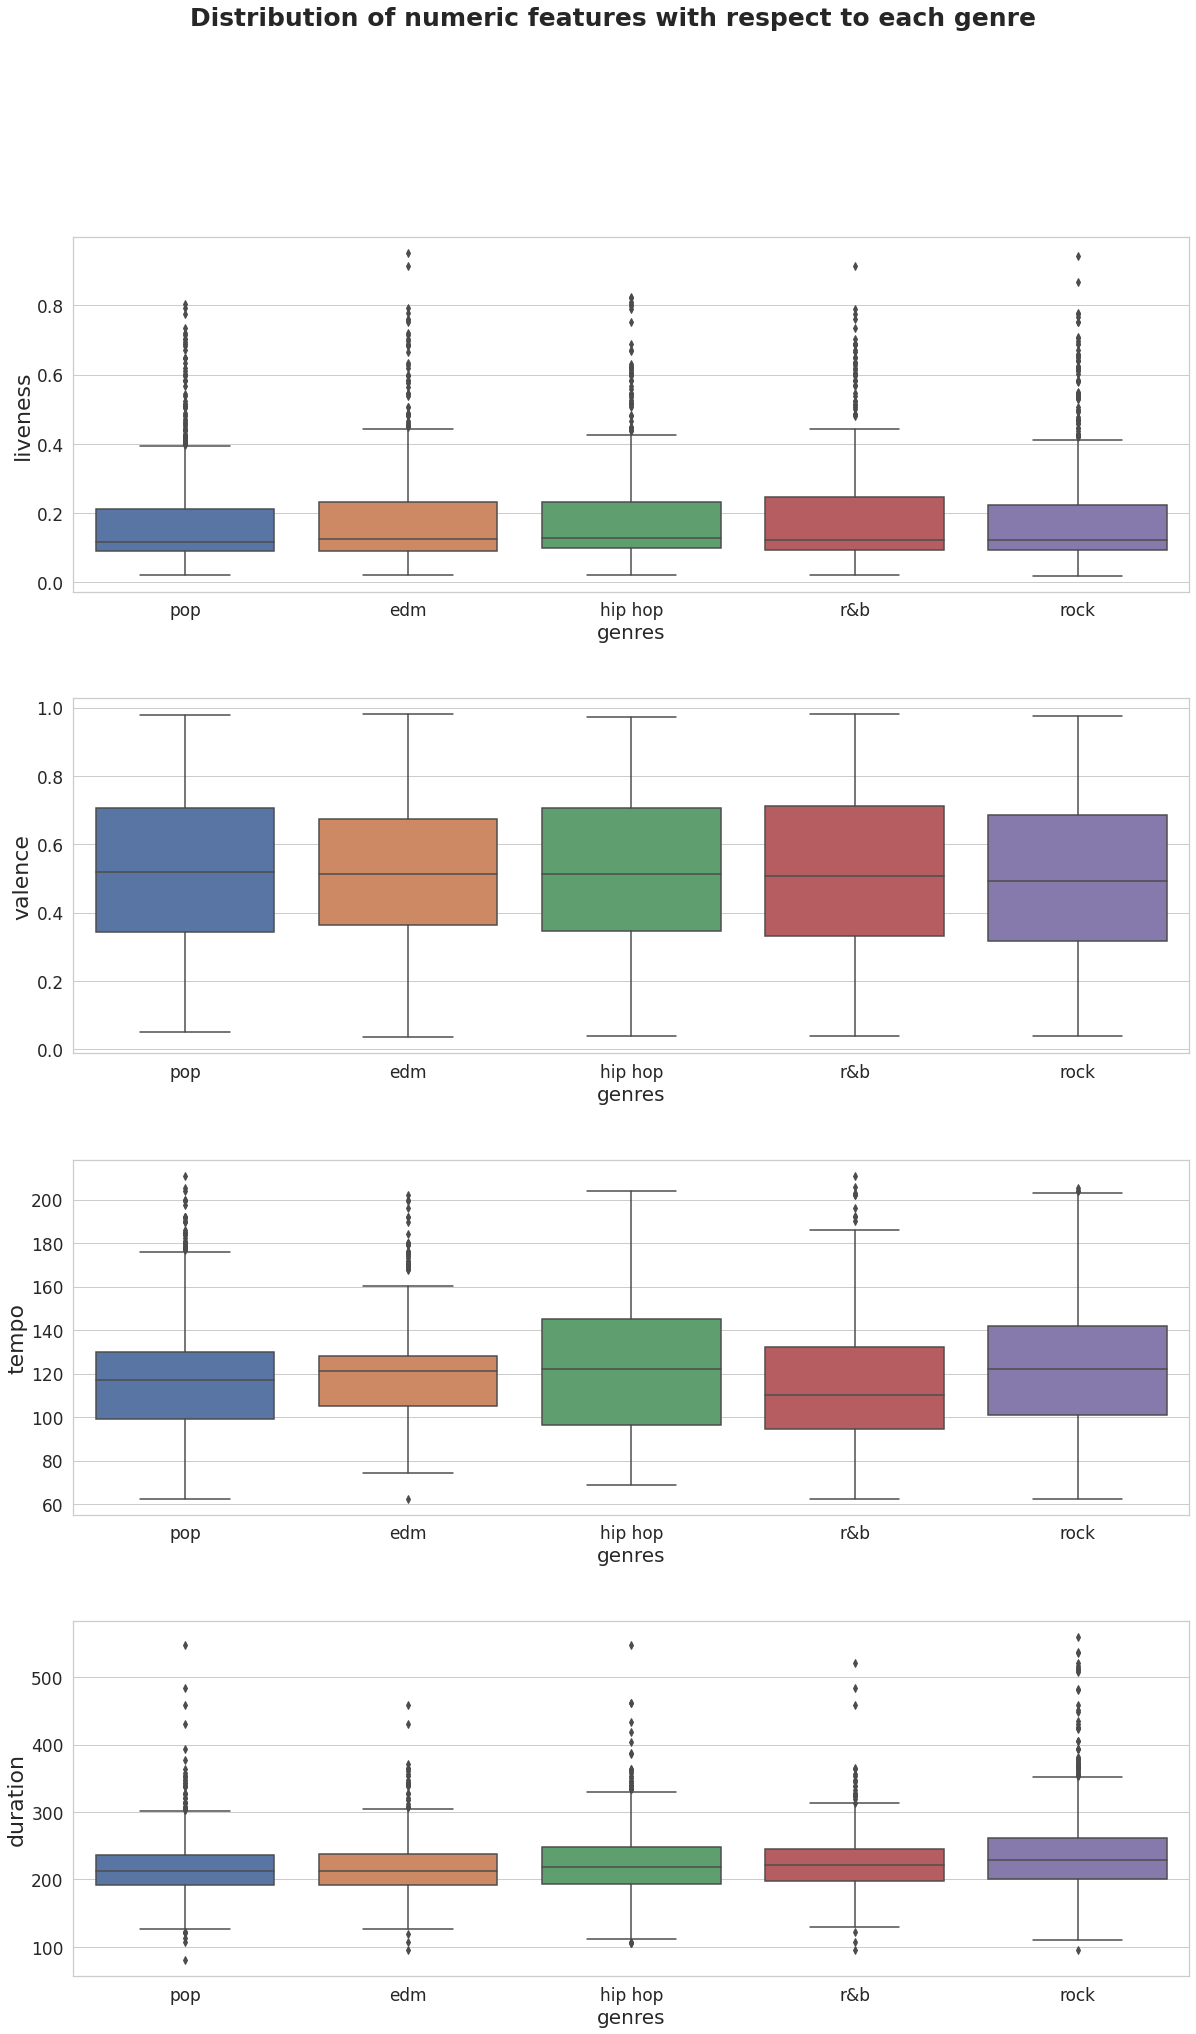

In [56]:
fig, ax = plt.subplots(len(no_instru) // 2, 1, figsize=(20, 8 * (len(no_instru) // 2)))
for i in range(len(no_instru) // 2, len(no_instru)):
    ax_ind = i % 4
    sns.boxplot(x="genres", y=no_instru[i], data=df_with_genre_sub,  ax=ax[ax_ind])
    ax[ax_ind].tick_params(labelsize=17)
    ax[ax_ind].set_ylabel(ax[ax_ind].get_ylabel(), fontsize=22)
    ax[ax_ind].set_ylabel(ax[ax_ind].get_ylabel(), fontsize=22)
    ax[ax_ind].set_xlabel(ax[ax_ind].get_xlabel(), fontsize=20)    
fig.suptitle('Distribution of numeric features with respect to each genre', fontsize=25, fontweight='bold')
fig.subplots_adjust(hspace=0.3)
# fig.tight_layout()
save_plot("num_var_genre_dist_2", fig)

#### Mode ration within each genre

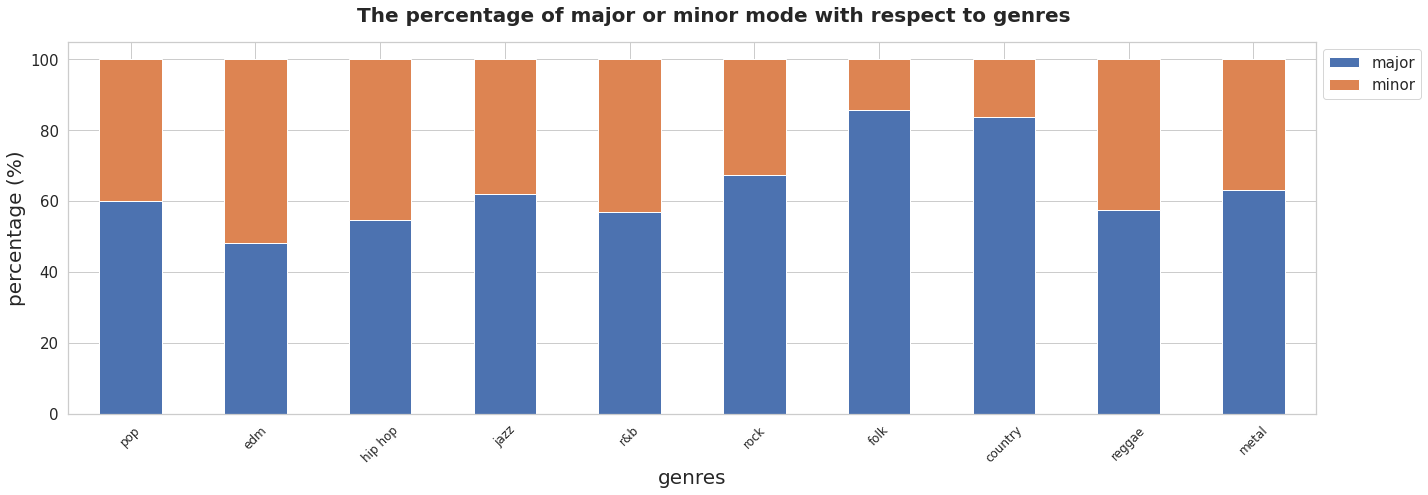

In [57]:
genre_mode = df_with_genre.groupby("genres")["mode"].value_counts()
genre_mode = pd.DataFrame(genre_mode).rename(
    columns={'mode': 'count'}).reset_index()
table = pd.pivot_table(genre_mode, values='count', index='mode',
                       columns=['genres'], aggfunc=np.sum)
table = table.astype(int)


def scale(series):
    return series / series.sum()


for col in table.columns:
    table[col] = scale(table[col])


mode_count = df_with_genre.value_counts(["genres", "mode"])
mode_table = pd.DataFrame({'genres': (df_with_genre.dropna())['genres'].unique(), 'major': [0.00 for i in range(10)], 
                      'minor': [0.00 for i in range(10)] })

for index, row in mode_table.iterrows():
    genre = row['genres']
    major_count =  mode_count[genre]['major']
    minor_count = mode_count[genre]['minor']
    count = major_count + minor_count

    mode_table.at[index,'major'] = ( major_count / count) * 100
    mode_table.at[index,'minor'] = (minor_count / count) * 100
mode_table.set_index('genres').plot(kind='bar', stacked=True, figsize = (20,7), fontsize = 15)
plt.legend(bbox_to_anchor=(1,1), fontsize = 15)
plt.gcf().suptitle("The percentage of major or minor mode with respect to genres",fontsize=20, fontweight="bold")
plt.xlabel('genres',size = 20)
plt.ylabel('percentage (%)',size = 20)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center', fontsize=12)
plt.tight_layout()
save_plot("mode_ratio_genre")

#### Explicit ratio within each genre

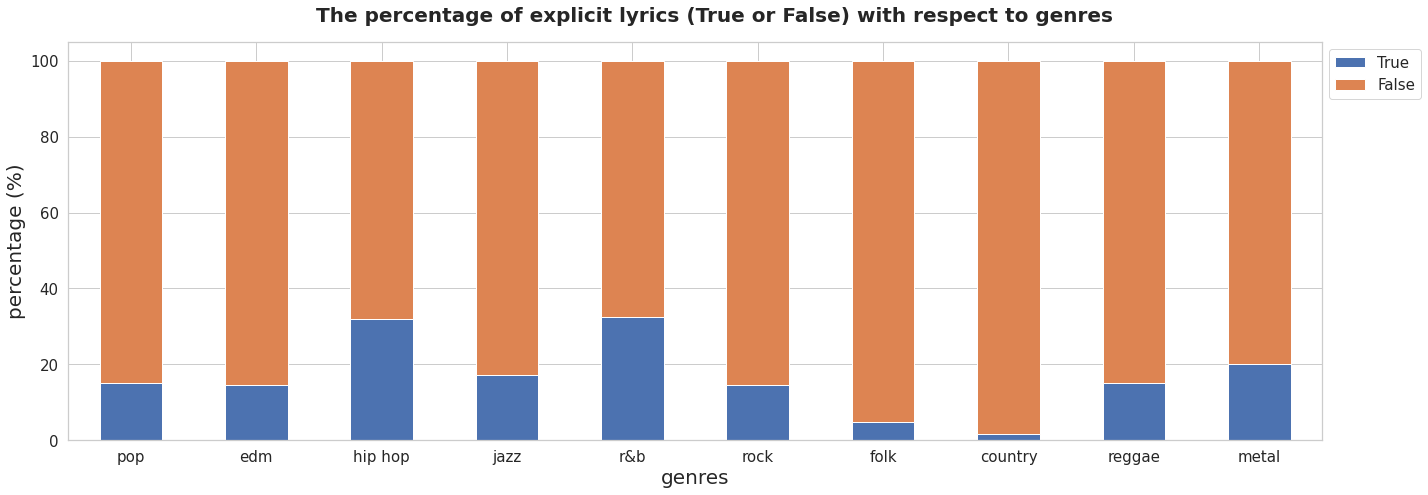

In [58]:
explicit_count = df_with_genre.value_counts(["genres", "explicit"])
explicit_table = pd.DataFrame({'genres': (df_with_genre.dropna())['genres'].unique(), 'True': [0.00 for i in range(10)], 
                      'False': [0.00 for i in range(10)] })

for index, row in explicit_table.iterrows():
    genre = row['genres']
    true_count =  explicit_count[genre][1]
    false_count = explicit_count[genre][0]
    count = true_count + false_count

    explicit_table.at[index,'False'] = (false_count / count) * 100
    explicit_table.at[index,'True'] = ( true_count / count) * 100

explicit_table.set_index('genres').plot(kind='bar', stacked=True, figsize = (20,7), fontsize = 15)
plt.legend(bbox_to_anchor=(1,1), fontsize = 15)
plt.gcf().suptitle("The percentage of explicit lyrics (True or False) with respect to genres",fontsize=20, fontweight="bold")
plt.xlabel('genres',size = 20)
plt.ylabel('percentage (%)',size = 20)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=15)
plt.tight_layout()
save_plot("explicit_ratio_genre")

### Artists analysis

#### Most popular artists

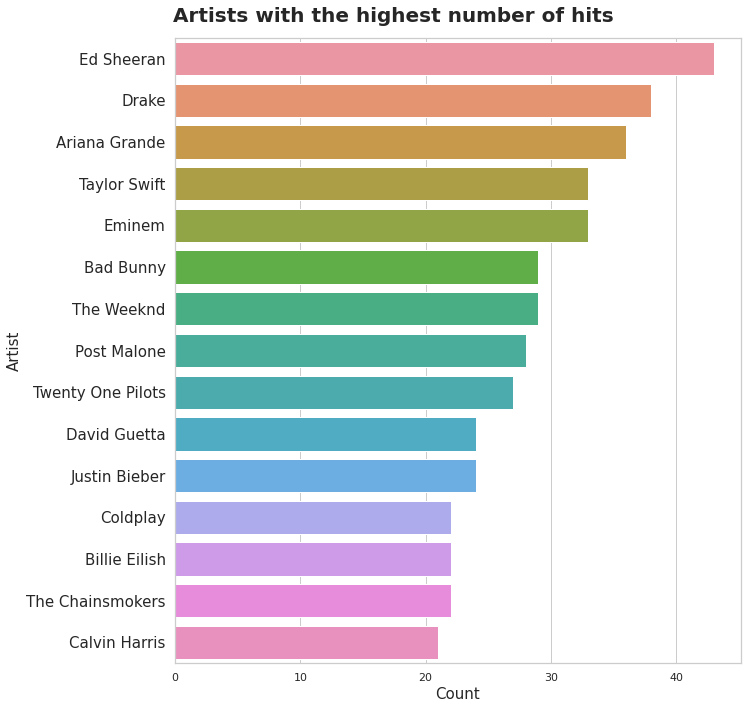

In [59]:
plt.figure(figsize=(10, 10))
df_no_various_artist = df[df["artist"] != "Various Artists"]
sns.countplot(y="artist", data=df_no_various_artist,
              order=df_no_various_artist['artist'].value_counts().index[0:15])
plt.suptitle("Artists with the highest number of hits", fontsize=20, fontweight="bold")
plt.tight_layout()
plt.xlabel("Count", fontsize=15)
plt.ylabel("Artist", fontsize=15)
plt.yticks(fontsize=15)
save_plot("most_pop_artist")

#### Most popular artists in each genre

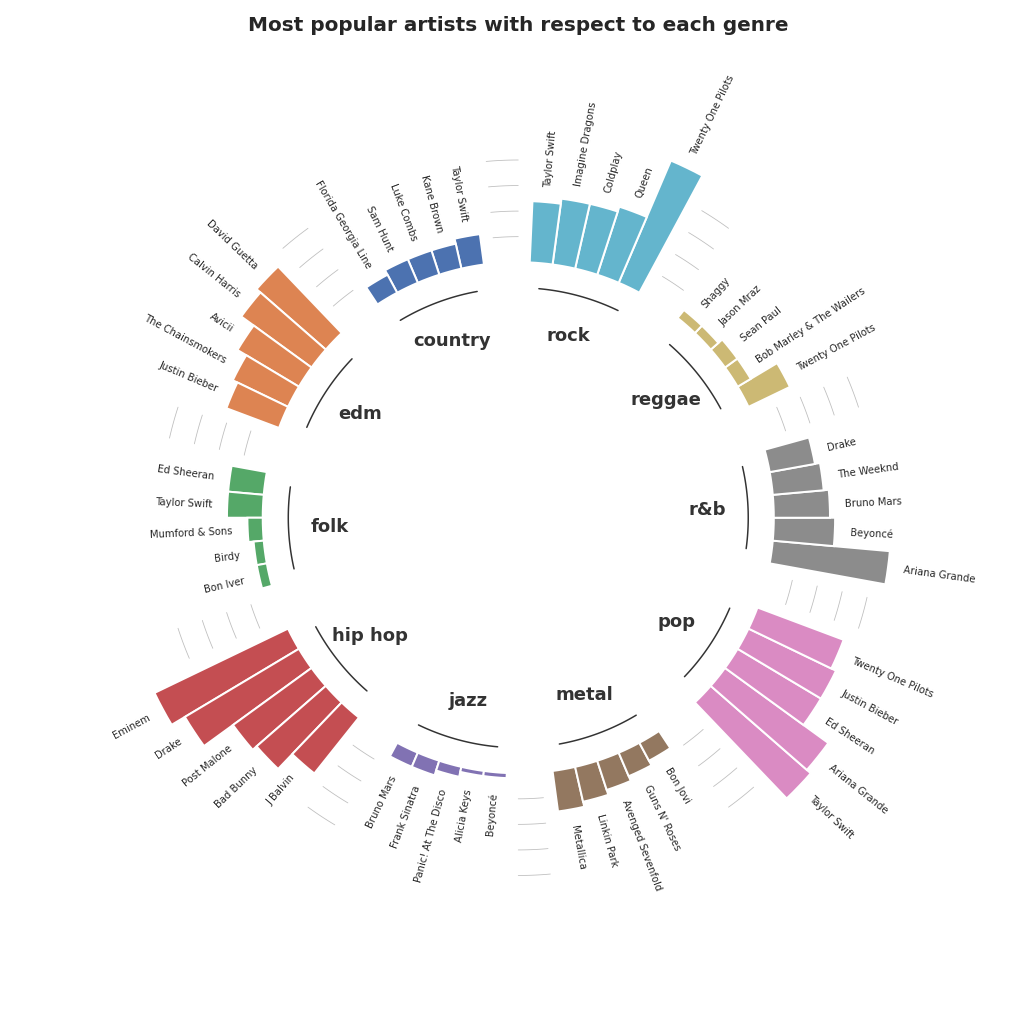

In [60]:
df_genre_sub = df_with_genre[['artist', 'playcount', 'genres']]
df_genre_sub.head()
cir_plot = df_genre_sub.groupby(['genres', 'artist'])[['playcount']].count().reset_index()
cir_plot = cir_plot.set_index('artist').groupby(['genres'])['playcount'].nlargest(5).reset_index()

# Grab the group values
GROUP = cir_plot["genres"].values
VALUES = cir_plot["playcount"].values
LABELS = cir_plot["artist"].values

# Add three empty bars to the end of each group
PAD = 2
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)
OFFSET = np.pi / 2

# Obtaining the right indexes is now a little more complicated
offset = 0
IDXS = []
GROUPS_SIZE = [5 for i in range(10)]
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD
# Same layout as above
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={"projection": "polar"})

ax.set_theta_offset(OFFSET)
ax.set_ylim(-50, 50)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Use different colors for each group!
COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

# And finally add the bars. 
# Note again the `ANGLES[IDXS]` to drop some angles that leave the space between bars.
ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

offset = 0 
for group, size in zip(cir_plot["genres"].unique(), GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -13, group, color="#333333", fontsize=18, 
        fontweight="bold", ha="center", va="center"
    )
    
    # Add reference lines at 20, 40, 60, and 80
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    ax.plot(x2, [5] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [10] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [15] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
    
    offset += size + PAD
fig.suptitle("Most popular artists with respect to each genre", fontsize=20, fontweight="bold", y=0.95)
fig.tight_layout()
save_plot("cir_bar", fig)

### Release date analysis
The original data is divided into 7 time periods:
- Before 1980: 225 songs
- 1980s: 177 songs
- 1990s: 222 songs
- 2000s: 521 songs
- From 2010 to 2014: 780 songs
- From 2015 to 2017: 1169 songs
- From 2018 to present: 1366 songs

##### Number of songs released in each 5-year interval

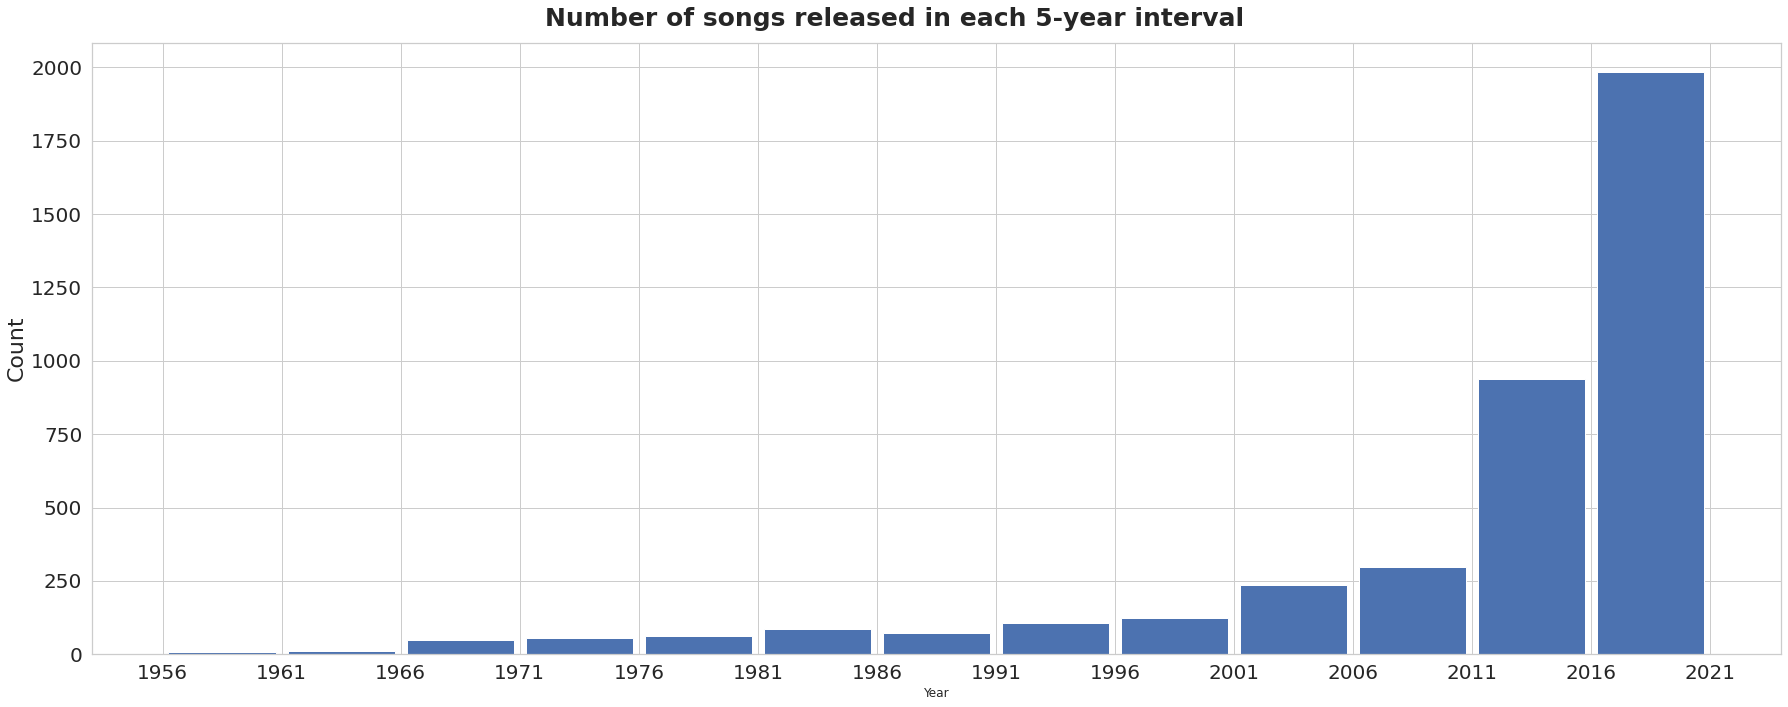

In [61]:
fig, ax = plt.subplots(figsize=(25, 10))
data = df["sp_release_date"]
data = [t.year for t in data]
number = np.arange(min(data), max(data) + 5, 5)
label = map(lambda x: str(x), number)
plt.hist(data, bins=number, rwidth=0.9)
plt.xticks(number, label)
plt.xlabel("Year")
plt.ylabel("Count")
plt.suptitle("Number of songs released in each 5-year interval", fontsize=25, fontweight='bold')
ax.tick_params(labelsize=20)
ax.set_ylabel("Count", fontsize=22)
fig.tight_layout()
save_plot("year_count")

#### Average playcounts by time period

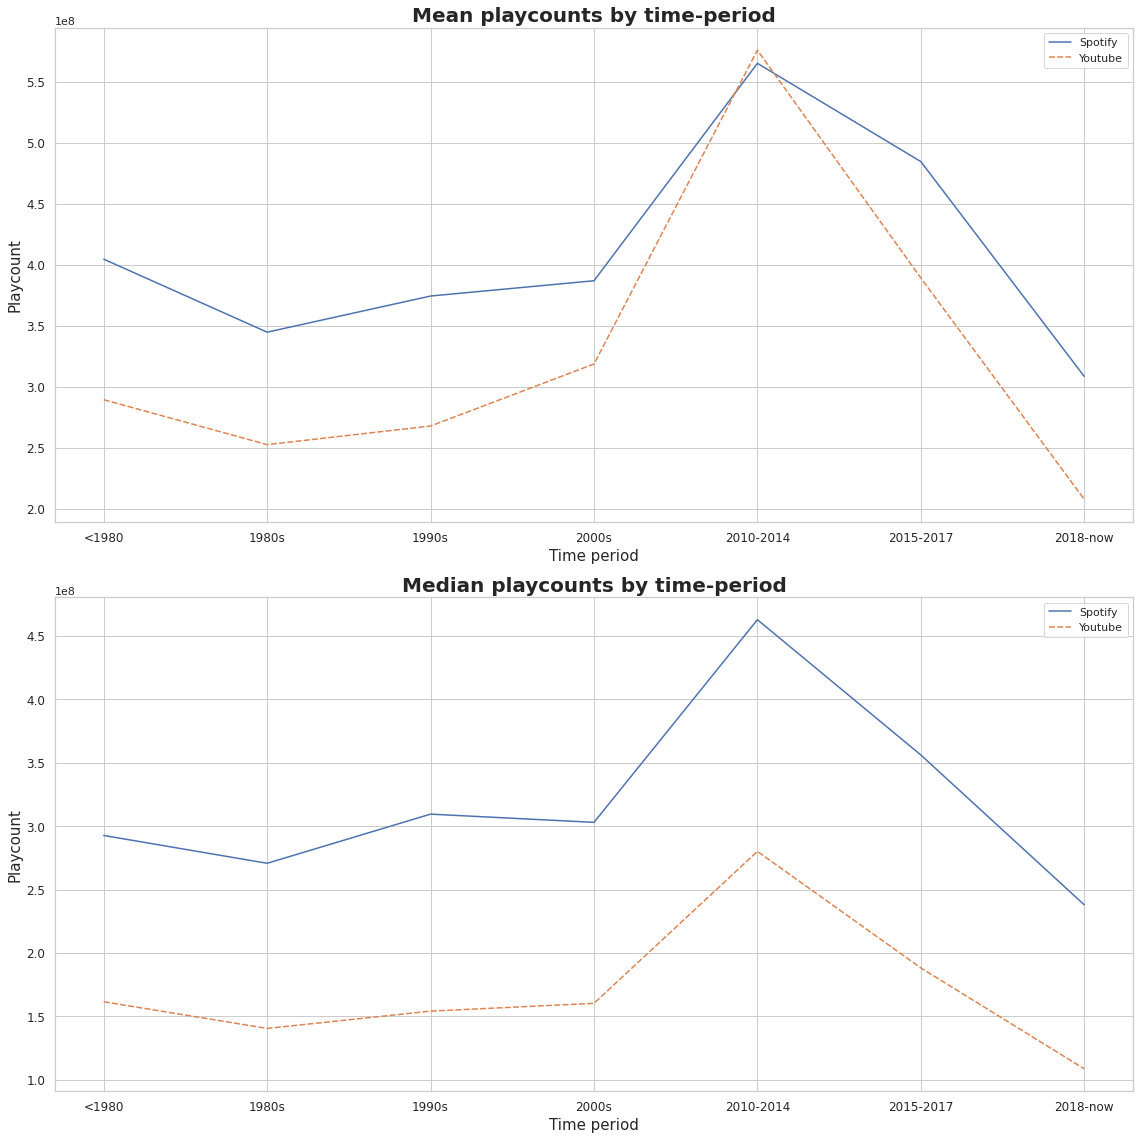

In [62]:
fig, ax = plt.subplots(2, 1, figsize=(16,16))
plot_popularity_by_eras(df_with_genre, ax=ax[0], mode='mean')
ax[0].set_title("Mean playcounts by time-period", fontsize=20, fontweight="bold")
ax[0].tick_params(labelsize=12)
ax[0].set_xlabel("Time period", fontsize=15)
ax[0].set_ylabel("Playcount", fontsize=15)
fig.tight_layout()

plot_popularity_by_eras(df_with_genre, ax=ax[1], mode='median')
ax[1].set_title("Median playcounts by time-period", fontsize=20, fontweight="bold")
ax[1].tick_params(labelsize=12)
ax[1].set_xlabel("Time period", fontsize=15)
ax[1].set_ylabel("Playcount", fontsize=15)
fig.tight_layout()
save_plot("play_era")

#### Most popular genres in each time period

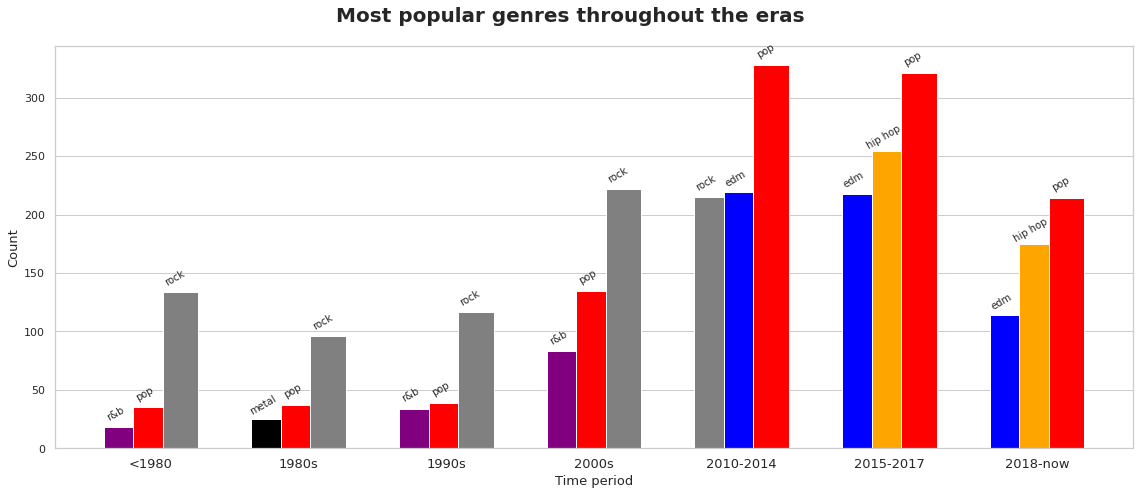

In [63]:
df_year_with_genre = df_with_genre.copy()
df_year_with_genre['year'] = df_year_with_genre['sp_release_date'].dt.year
eras_df = discretize(data=df_year_with_genre, col='year', value_range=eras, inf='both')
genre_count_by_eras = eras_df.groupby(["year", "genres"])["playcount"].count().reset_index()

year_counts = []
for i in range(7):
    year_count = genre_count_by_eras[genre_count_by_eras['year'] == i]
    year_count = year_count.sort_values(by=['playcount'], ascending = False)
    year_counts.append(year_count[0:3][::-1])


genre_count_by_eras = year_counts[0]
for i in range(1,7):
    genre_count_by_eras = genre_count_by_eras.append(year_counts[i])
genre_count_by_eras.rename(columns={"yeear":"era", "playcount": "count"}, inplace=True)
fig, ax = plt.subplots(figsize = (16,7)) 
val = []
label = []
color = []
col_pad = 2
genres = list(genre_count_by_eras["genres"].unique())
genre_color = {
    "r&b" : "purple",
    "pop" : "red",
    "metal" : "black",
    "rock" : "grey",
    "edm" : "blue",
    "hip hop" : "orange",
    "jazz" : "green"
}
for i in range(len(genre_count_by_eras)):
    if i % 3 == 0 and i != 0:
        val += [0 for i in range(col_pad)]
        label += ["" for i in range(col_pad)]
        color += ["C1" for i in range(col_pad) ]
    val.append(genre_count_by_eras['count'].iloc[i])
    genre = genre_count_by_eras['genres'].iloc[i]
    label.append(genre)
    color.append(genre_color[genre])
ax.bar(range(len(val)), val, width=1.2, color=color)
for i in range(len(val)):
    ax.text(
            x=i-0.2, 
            y=val[i] + 12, 
            s=label[i], 
            ha='center', 
            va="center", 
            fontsize=10,
            rotation=30
        )
eras_name = ["<1980", "1980s", "1990s", "2000s", "2010-2014", "2015-2017", "2018-now"]
xticks = []
for i in range(len(val)):
    if i % 5 == 1:
        xticks.append(eras_name[i // 5])
    else:
        xticks.append("")
ax.set_xticks(np.arange(len(val)), xticks, fontsize = 13)
ax.set_xlabel("Time period", fontsize = 13)
ax.set_ylabel('Count', fontsize = 13)
ax.grid(False, axis='x')
fig.suptitle('Most popular genres throughout the eras', fontsize = 20, fontweight = 'bold')
fig.tight_layout()
save_plot('genre_time_bar')